In [2]:
%config InlineBackend.figure_format = 'retina'

# Statistical Analysis and Simulation of the Cell Life Cycle


    MD Arifuzzaman, 
    Dept of Computer Science & Engineering,
    Bangladesh University of Engineering & Technology.

# Problem Specification

In life cycle of a cell, at some stage it divides to create new cells. In phenomena of a cell division, at first it starts to grow. Growth is exponential random time ʎ. When growth completes, it starts replicating DNA. This DNA replication occurs with service time µ1 following normal random distribution. After replicating DNA, the cell joins for completing mitosis division with normal random time. Without replication of DNA this mitosis stage cannot occur.  In mitosis stage, a cell divides into two each with one DNA created during replication phase taking normal random distribution time µ2. The divided cells can be alive with 2/3 probability. If cell is alive then each of them again go for next cell division. More than one cell division may occur simultaneously and Maximum M numbers of cell can present at a single time. So, simulation stops when present cell count hits M.

# Cell Cycle

The cell cycle, or cell-division cycle, is the series of events that take place in a cell leading to its division and duplication (replication) that produces two daughter cells.

![title](images/cell-cycle.jpg)

# Simulation

Now, We have two queue (C1 and C2) and Two server (D and M). If a cell origins, then it arrives atqueue C1. Then started to grow. If it becomes big enough then it waiting period is over, it goes to server D. at server D, DNA replication process starts. After Successful replication it leaves sever D and joins queue C2. If server M becomes free, then it joins to server M. Server M checks if mitosis completes or not. If completed then cell divides into two daughter cells.

For any living body, if there is sufficient protein, only then cell growth starts and when it becomes big enough DNA replication starts instantly. But here in simulation, we have K server, if more than k cell is ready for DNA replication, they have to wait in line.

As, there is a limit of how many cell gonna survive in a living body, we will set a limit for Maximum
numbers of cell can presence in any specific time. Simulation will be suspended if present cell count hit
that limit and if any cell damages then simulation starts again.

## For Human :

	$ Typical Cell Life Cycle Time 24 Hours
		- Growth Stage - 11 Hours
		- Replication Stage - 8 Hours
		- Mitosis Division Stage - 5 Hours

## Life Cycle Stage:

	G0 - 1st All Present Cell Start to Grow
	W1 - After Growth, All Cell Waits Some Times
	R0 - Now All Cell Start to Replicate it's DNA
	W2 - After Replication 2nd Waiting Periods Begun
	M0 - Finally Mitosis Cell Division Takes Place

## Growth >>> Wait >>> Replicate >>> Wait >>> Divide >>> Repeat

## In Simulation:

	$ Three Server
		- Growth
		- Replication
		- Division

	$ Only One Server Active at a Time
	$ Three Queue For Three Server
	$ Time Simulation Time = (Growth+Replication+Division) Server Time

	$ Random Distribution
		- Growth Server - Exponential (beta = .091, as lamda = 11)
		- Replication Server - Normal (mu = 8)
		- Division - Normal (mu = 5)

	$ In Human Body There Are Infinite Server, But Here in Simulation
		- Growth Server Count : Infinite
		- Replication Server Count : Finite
		- Division Server Count : Finite

	$ Priority Queue
		- Growth
			- Standar Queue > FCFS : First Come Frist Serve
		- Replication and Division
			- Heap Queue

![title](images/use-case.png)

# Import Python Modules

In [2]:
import heapq
import random
import matplotlib.pyplot as plt

# Global Variables

In [3]:
cellLimit  = 0
simClock = 0

growthQueue = [] # Cell Growth Queue
replicationQueue = [] # Replication Server Queue
divisionQueue = [] # Division Server Queue

# Server Count
totalReplicationServer = 0
totalDivisionServer = 0

# Mean, Variance
beta = 0.091 # Mean, Exponential Distribution
mu_Replicate = 8 # Mean, Normal Distribution
mu_Division = 5 # Mean, Normal Distribution
sigma = 1 # Standard Deviation, Normal Distribution

# Results
# gs - Growth Server
# rs - Replication Server
# ds - Division Server
gsServiceTime, rsWaitingTime, rsServiceTime, dsWaitingTime, dsServiceTime = [], [], [], [], []
growthServerUse, replicationServerUse, divisionServerUse = [], [], []
divided, dead = 0, 0
cellCount = 1

# Helper Function : Log Entry Every Activities

In [4]:
def log(activity):
    with open("simulation-outputs.txt", "a+") as ff:
        try:
            ff.write(activity)
            ff.write("\n")
        except Exception as e:
            print(e)

# Growth Server
    =>> Here Cell Growth Started
    =>> Cell Growth Time Follows Exponential Distribution

In [5]:
class Growth:
    def __init__(self):
        self.run()

    def run(self):
        global simClock
        temp = []
        while True:
            if len(growthQueue) < cellLimit:
                if len(growthQueue) == 0:
                    growthQueue.append(1)
                    log("1st Cell is Created!!")

                while len(growthQueue) > 0:
                    cellNumber = growthQueue.pop(0)
                    log("Cell %d has Started to Grow at %d" % (cellNumber, simClock))

                    growthTime = random.expovariate(0.091)
                    gsServiceTime.append(growthTime)
                    joinQueue = simClock+growthTime
                    replicationQueue.append(joinQueue)
                    temp.append(growthTime)
                    log("Cell %d Completes it's Growth at %d" % (cellNumber, simClock))
                    log("Cell %d Joins Replication Server Queue at %d" % (cellNumber, simClock))

                #print(gsServiceTime)
                #print(replicationQueue)
                heapq.heapify(replicationQueue)
                #print(replicationQueue)
                #print()
                high = max(temp) # Maximum Growth time
                # As Infinite in Size, Growth Server remain active till maximum Growth time for this instance
                simClock = simClock+high
                growthServerUse.append(high)
                new_Replication = Replication()
            else:
                break

# Replication Server
    =>> When Growth Completes Cell Joins to Replication Server Queue
    =>> Here Cell Waits for Replication Server to Become Free
    =>> Replication Server - Here DNA Replication Occurs.
    =>> DNA Replication Time Follows Normal Distribution

In [6]:
class Replication:
    def __init__(self):
        self.run()

    def run(self):
        global simClock
        # a - arrival, ss - service start, w - wait, s - service, se - service end, ts - total service
        aTime = ssTime = wTime = sTime = seTime = tsTime = 0
        start,end = 0,0
        # Keeping Track of Service End Time
        last_k_serviceEndTime = []

        N = len(replicationQueue)
        #print(N)
        if N > 0:
            # All Cell Waited Till SimClock. at Simclock Replication Server become active
            start = simClock
            if N<=totalReplicationServer:
                for x in range(N):
                    aTime = replicationQueue.pop(0)
                    ssTime = max(simClock,aTime)
                    wTime = ssTime - aTime
                    sTime = self.server(ssTime)
                    seTime = ssTime+sTime
                    end = max(end,seTime)
                    rsWaitingTime.append(wTime)
                    rsServiceTime.append(sTime)
            else:
                for x in range(totalReplicationServer):
                    aTime = replicationQueue.pop(0)
                    ssTime = max(simClock,aTime)
                    wTime = ssTime - aTime
                    sTime = self.server(ssTime)
                    seTime = aTime+sTime
                    end = max(end,seTime)
                    rsWaitingTime.append(wTime)
                    rsServiceTime.append(sTime)
                    last_k_serviceEndTime.append(seTime)

                while len(replicationQueue) > 0:
                    aTime = replicationQueue.pop(0)
                    '''
                    min(last_k_serviceEndTime) - when, atleast one server will become Free
                    if arrival time > min(last_k_serviceEndTime)
                        then atleast one server free, jonis immediately
                    else
                        server busy, wait for server to become free
                    '''
                    ssTime = max(simClock,aTime,min(last_k_serviceEndTime))
                    wTime = ssTime - aTime
                    sTime = self.server(ssTime)
                    seTime = ssTime+sTime
                    end = max(end,seTime)
                    rsWaitingTime.append(wTime)
                    rsServiceTime.append(sTime)

                    # 1st server to become free, will be taken, so remove it from free list
                    last_k_serviceEndTime.sort()
                    last_k_serviceEndTime.pop(0)

                    # now, append when acquired server will become free
                    last_k_serviceEndTime.append(seTime)

        #print(rsWaitingTime)
        #print(rsServiceTime)
        #print()

        # now, server remain till last cell service end time
        tsTime = end-start
        replicationServerUse.append(tsTime)
        #print(divisionQueue)
        heapq.heapify(divisionQueue)
        #print(replicationQueue)
        #print()
        simClock += tsTime
        new_Division = Division()
    
    # Replication Server - Here DNA Replication Occurs.
    # DNA Replication Time Follows Normal Distribution
    def server(self, servStartTime):
        random_num = random.normalvariate(mu_Replicate, sigma**2)
        serviceTime = abs(random_num)
        temp = servStartTime+serviceTime
        divisionQueue.append(temp)
        return serviceTime

# Division Server
    =>> When DNA Replication Completes Cell Joins to Division Server Queue
    =>> Here Cell Waits for Division Server to Become Free
    =>> Division Server - Here Cell Divides itself into Two New Cells
    =>> Service Time Follows Normal Distribution

In [7]:
class Division:
    def __init__(self):
        self.run()

    def run(self):
        global simClock
        # a - arrival, ss - service start, w - wait, s - service, se - service end, ts - total service
        aTime = ssTime = wTime = sTime = seTime = tsTime = 0
        start,end = 0,0
        # Keeping Track of Service End Time
        last_k_serviceEndTime = []

        N = len(divisionQueue)
        #print N
        if N > 0:
            # All Cell Waited Till SimClock. at Simclock Division Server become active
            start = simClock
            if N<=totalDivisionServer:
                for x in range(N):
                    aTime = divisionQueue.pop(0)
                    ssTime = max(simClock,aTime)
                    wTime = ssTime - aTime
                    sTime = self.server()
                    seTime = ssTime+sTime
                    end = max(end,ssTime)
                    dsWaitingTime.append(wTime)
                    dsServiceTime.append(sTime)
            else:
                for x in range(totalDivisionServer):
                    aTime = divisionQueue.pop(0)
                    ssTime = max(simClock,aTime)
                    wTime = simClock - aTime
                    sTime = self.server()
                    seTime = ssTime+sTime
                    end = max(end,seTime)
                    dsWaitingTime.append(wTime)
                    dsServiceTime.append(sTime)
                    last_k_serviceEndTime.append(seTime)

                while len(divisionQueue) > 0:
                    aTime = divisionQueue.pop(0)
                    '''
                    min(last_k_serviceEndTime) - when atleast one server will become Free
                    if arrival time > min(last_k_serviceEndTime)
                        then atleast one server free, jonis immediately
                    else
                        server busy, wait for server to become free
                    '''
                    ssTime = max(simClock,aTime,min(last_k_serviceEndTime))
                    wTime = ssTime - aTime
                    sTime = self.server()
                    seTime = ssTime+sTime
                    end = max(end,seTime)
                    dsWaitingTime.append(wTime)
                    dsServiceTime.append(sTime)

                    # 1st server to become free, will be taken, so remove it from free list
                    last_k_serviceEndTime.sort()
                    last_k_serviceEndTime.pop(0)

                    # now, append when acquired server will become free
                    last_k_serviceEndTime.append(seTime)

        # now, server remain till last cell service end time
        tsTime = end-start
        divisionServerUse.append(tsTime)
        simClock += tsTime
        # Growth Queue : FCFS - First Come First Serve
        growthQueue.sort()


    # Division Server - Here Cell Divides itself into Two New Cells
    # Service Time Follows Normal Distribution
    def server(self):
        global divided, dead, cellCount

        # random.gauss - More Efficient Implementation of Normal Distribution
        random_num = random.normalvariate(mu_Division,sigma**2)
        serviceTime = abs(random_num)

#         if len(growthQueue) == 0:
#             num = len(gsServiceTime)
#         else:
#             num = growthQueue[-1]
        
        num = cellCount
        cellCount +=2 

        log("A Cell Completes it's Division at %d and Created Two New Cell %d and %d" % 
            (simClock, num+1, num+2))
        divided = divided+1

        if self.alive():
            if len(growthQueue)>=cellLimit:
                dead = dead+1
            else:
                growthQueue.append(num+1)
                log("Yeah!! Cell %d is Alive and Joined Cell Growth Queue" % (num+1))
        else:
            dead = dead+1
            log("Alas!! Cell %d Has Been Died." % (num+1))

        if self.alive():
            if len(growthQueue)>=cellLimit:
                dead = dead+1
            else:
                growthQueue.append(num+2)
                log("Yeah!! Cell %d is Alive and Joined Cell Growth Queue" % (num+2))
        else:
            dead = dead+1
            log("Alas!! Cell %d Has Been Died." % (num+2))

        log("Total Cell Present : %d" % len(growthQueue))
        return serviceTime


    # Checks if Newly Created Cell is Dead or Alive
    def alive(self):
        num = random.randint(1,3)
        if num == 3:
            return False
        else:
            return True

# Helper Function : Reset All Value, Prepare for New Simulation

In [8]:
def reset(limit, rsCount, dsCount):
    try:
        %rm simulation-outputs.txt
    except Exception as e:
        print(e)
        
    global cellLimit, totalReplicationServer, totalDivisionServer
    global growthQueue, replicationQueue, divisionQueue
    global gsServiceTime, rsWaitingTime, rsServiceTime, dsWaitingTime, dsServiceTime
    global growthServerUse, replicationServerUse, divisionServerUse
    global divided, dead, simClock, cellCount

    cellLimit, totalReplicationServer, totalDivisionServer = limit, rsCount, dsCount
    growthQueue, replicationQueue, divisionQueue = [], [], []
    gsServiceTime, rsWaitingTime, rsServiceTime, dsWaitingTime, dsServiceTime = [], [], [], [], []
    growthServerUse, replicationServerUse, divisionServerUse = [], [], []
    simClock, cellCount, divided, dead = 0, 1, 0, 0

# Helper Function : Run Simulation

In [9]:
def run(limit, rsCount, dsCount):
    reset(limit, rsCount, dsCount)
    new_Simu = Growth()

# Set Required Parameters

In [10]:
seed = 100
max_cell = 10
replication_server_count = 2
division_server_count = 1

# Statistical Outputs

In [11]:
random.seed(seed)
run(max_cell, replication_server_count, division_server_count)
print("\nAs Present Cell Count Hits %d, Simulation Stop.\n" % cellLimit)
Avg_gsServiceTime = sum(gsServiceTime) / float(len(gsServiceTime))
Avg_rsWaitingTime = sum(rsWaitingTime) / float(len(rsWaitingTime)) / totalReplicationServer
Avg_dsWaitingTime = sum(dsWaitingTime) / float(len(dsWaitingTime)) / totalDivisionServer
Avg_rsServiceTime = sum(rsServiceTime) / float(len(rsServiceTime))
Avg_dsServiceTime = sum(dsServiceTime) / float(len(dsServiceTime))
Avg_lt = Avg_gsServiceTime+Avg_rsServiceTime+Avg_dsServiceTime
gsUtility = (sum(growthServerUse) / float(simClock)) * 100
dsUtility = (sum(replicationServerUse) / float(simClock)) * 100
msUtility = (sum(divisionServerUse) / float(simClock)) * 100

print("**** Simulation Statistics ****")
print()
print("Mean - Growth Server (Exponential Distribution) = %3.2f" % (1/beta))
print("Mean - Replication Server (Normal Distribution) = %3.2f" % (mu_Replicate))
print("Mean - Division Server (Normal Distribution) = %3.2f" % (mu_Division))
print("Standard Deviation - Division Server (Normal Distribution) = %3.2f" % (sigma))
print()
print("Replication Server Count = %d" % (totalReplicationServer))
print("Division Server Count = %d" % (totalDivisionServer))
print()
print("Total Cell Divided : %d" % divided)
print("Total Dead Cell : %d" % dead)
print("Currently Alive Cell : %d" % len(growthQueue))
print()
print("Average Cell Growth Time : %5.2f hours" % Avg_gsServiceTime)
print("Average Replication Server Queue Waiting Time : %5.2f hours" % Avg_rsWaitingTime)
print("Average Replication Server Service Time : %5.2f hours" % Avg_rsServiceTime)
print("Average Division Server Queue Waiting Time : %5.2f hours" % Avg_dsWaitingTime)
print("Average Division Server Service Time : %5.2f hours" % Avg_dsServiceTime)
print("Average Life Time of a Cell : %5.2f hours" % Avg_lt)
print()
print("Total Simulation Time : %5d hours" % simClock)
print("Total Growth Server Service Time : %5d hours" % sum(growthServerUse))
print("Growth Server Utilization : %5.2f%s" % (gsUtility,"%"))
print("Total Replication Server Service Time : %5d hours" % sum(replicationServerUse))
print("Replication Server Utilization : %5.2f%s" % (dsUtility,"%"))
print("Total Division Server Service Time : %5d hours" % sum(divisionServerUse))
print("Division Server Utilization : %5.2f%s" % (msUtility,"%"))


As Present Cell Count Hits 10, Simulation Stop.

**** Simulation Statistics ****

Mean - Growth Server (Exponential Distribution) = 10.99
Mean - Replication Server (Normal Distribution) = 8.00
Mean - Division Server (Normal Distribution) = 5.00
Standard Deviation - Division Server (Normal Distribution) = 1.00

Replication Server Count = 2
Division Server Count = 1

Total Cell Divided : 41
Total Dead Cell : 32
Currently Alive Cell : 10

Average Cell Growth Time : 10.35 hours
Average Replication Server Queue Waiting Time : 14.67 hours
Average Replication Server Service Time :  7.73 hours
Average Division Server Queue Waiting Time : 18.00 hours
Average Division Server Service Time :  4.80 hours
Average Life Time of a Cell : 22.88 hours

Total Simulation Time :   652 hours
Total Growth Server Service Time :   332 hours
Growth Server Utilization : 50.94%
Total Replication Server Service Time :   155 hours
Replication Server Utilization : 23.90%
Total Division Server Service Time :   164 ho

# Average Waiting Time Vs Server Count
    =>> Expectation : As server count increases, waiting time decreases

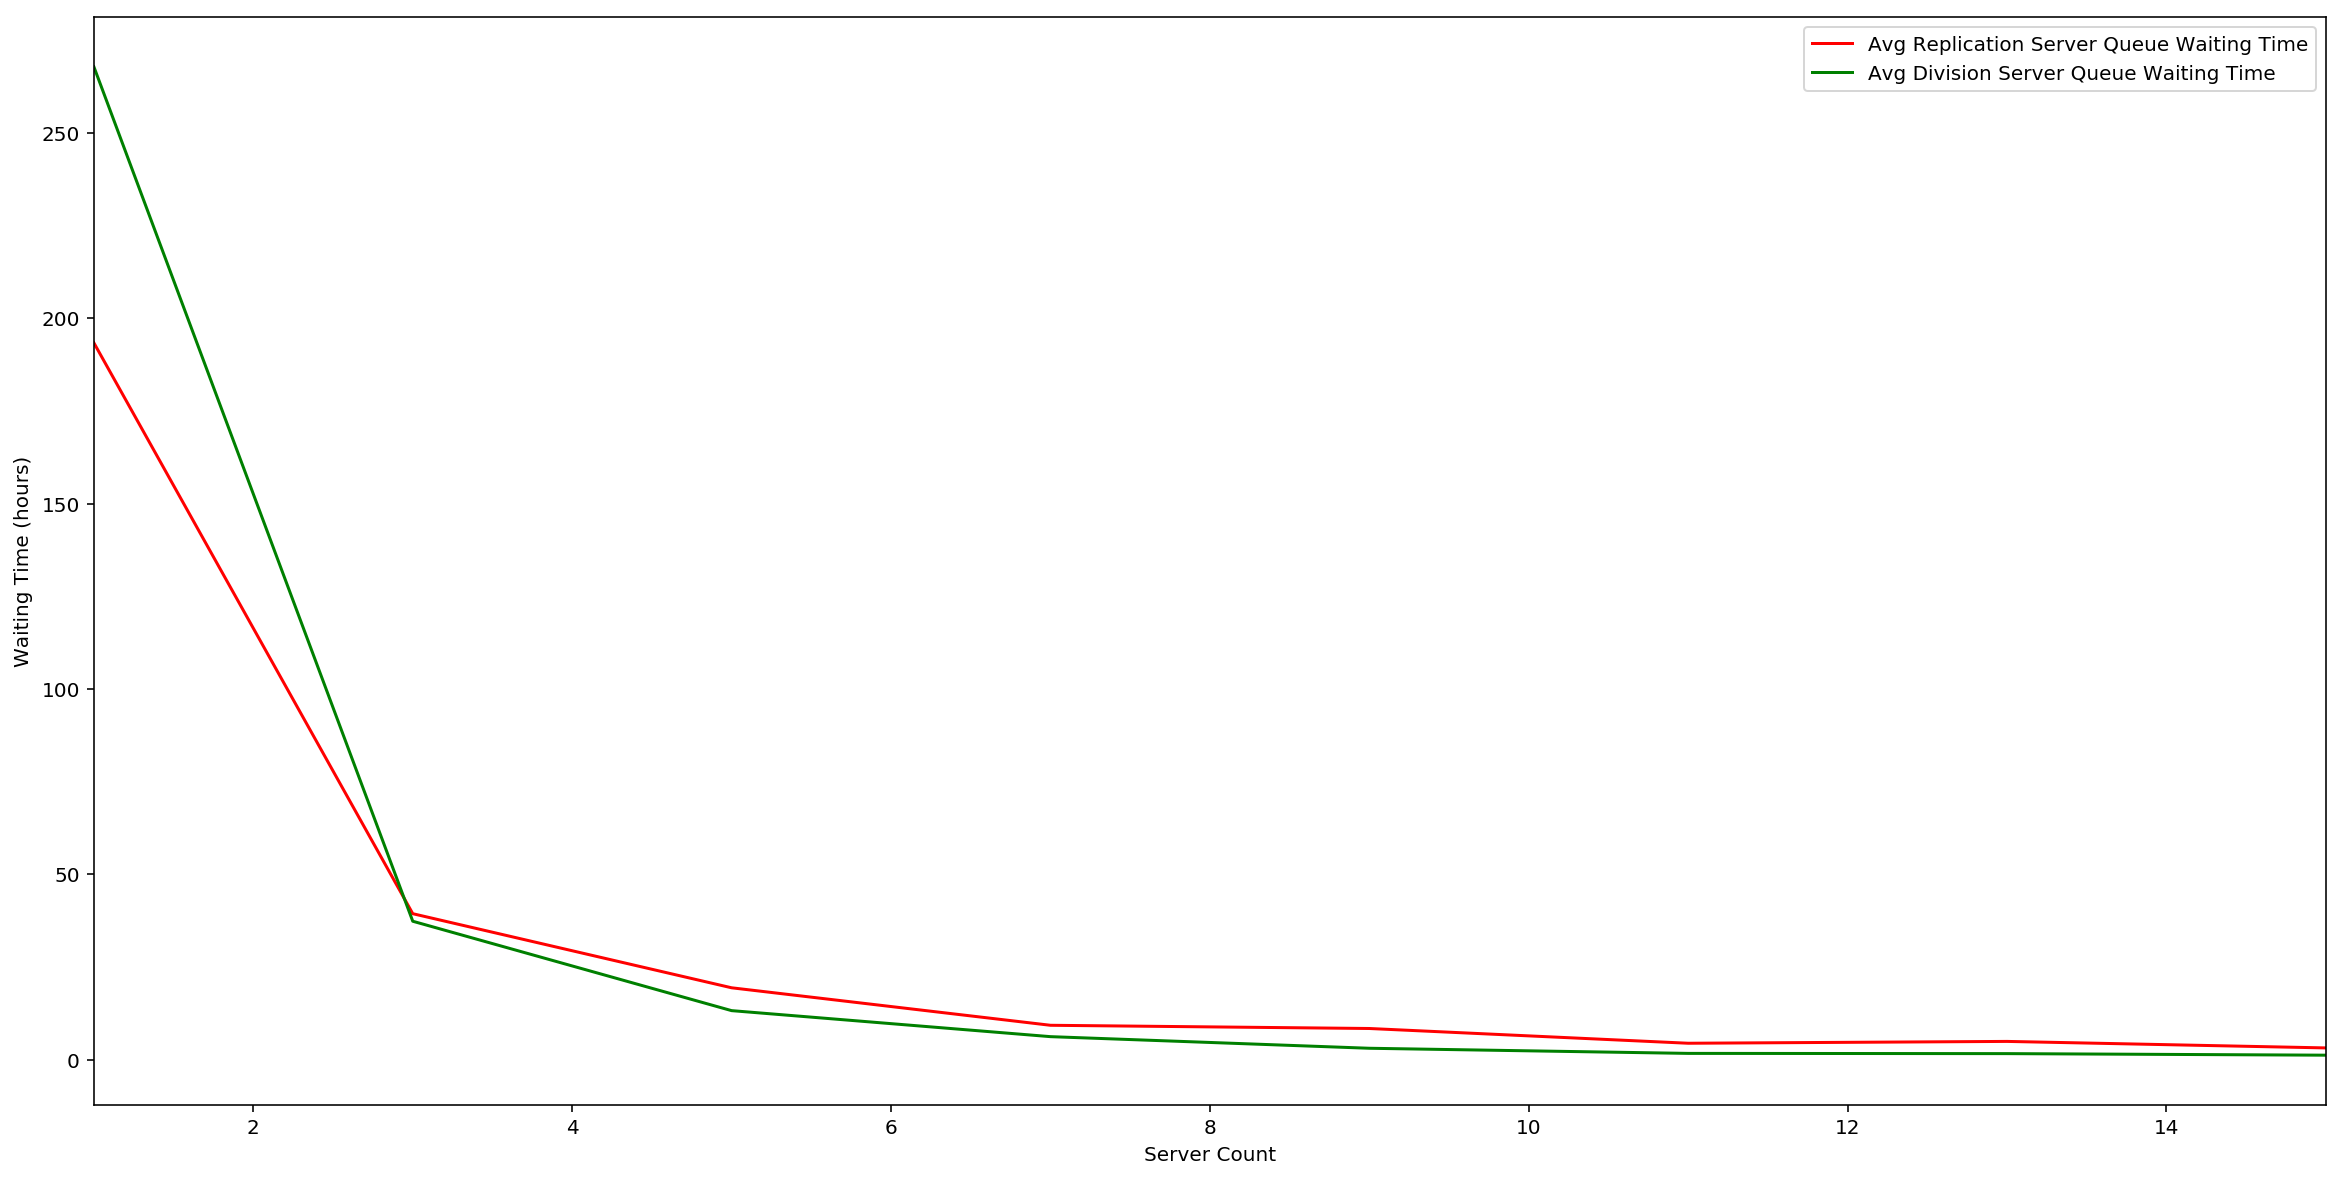

In [12]:
random.seed(100)
X, Y1, Y2 = [], [], []

for x in range(1, 16, 2):
    totalReplicationServer = x
    totalDivisionServer = x
    run(100, totalReplicationServer, totalDivisionServer)
    Avg_rsWaitingTime = sum(rsWaitingTime) / float(len(rsWaitingTime)) / totalReplicationServer
    Avg_dsWaitingTime = sum(dsWaitingTime) / float(len(dsWaitingTime)) / totalDivisionServer
    X.append(x)
    Y1.append(Avg_rsWaitingTime)
    Y2.append(Avg_dsWaitingTime)

plt.figure(figsize=(20,10))
dna, = plt.plot(X,Y1,'r-',label='dnaWaitQueue')
mitosis, = plt.plot(X,Y2,'g-',label='msWaitQueue')
plt.legend([dna, mitosis], ['Avg Replication Server Queue Waiting Time', 'Avg Division Server Queue Waiting Time'])
# plt.suptitle("Average Waiting Time Vs Server Count", fontsize=15)
plt.xlabel("Server Count")
plt.ylabel("Waiting Time (hours)")
plt.xlim([1,15])
plt.show()

# Server Utilization Vs Server Count
        ==> Expectation: As more and more replication and division server added, server utilization will be reduced, thus increasing growth server utilization percentage

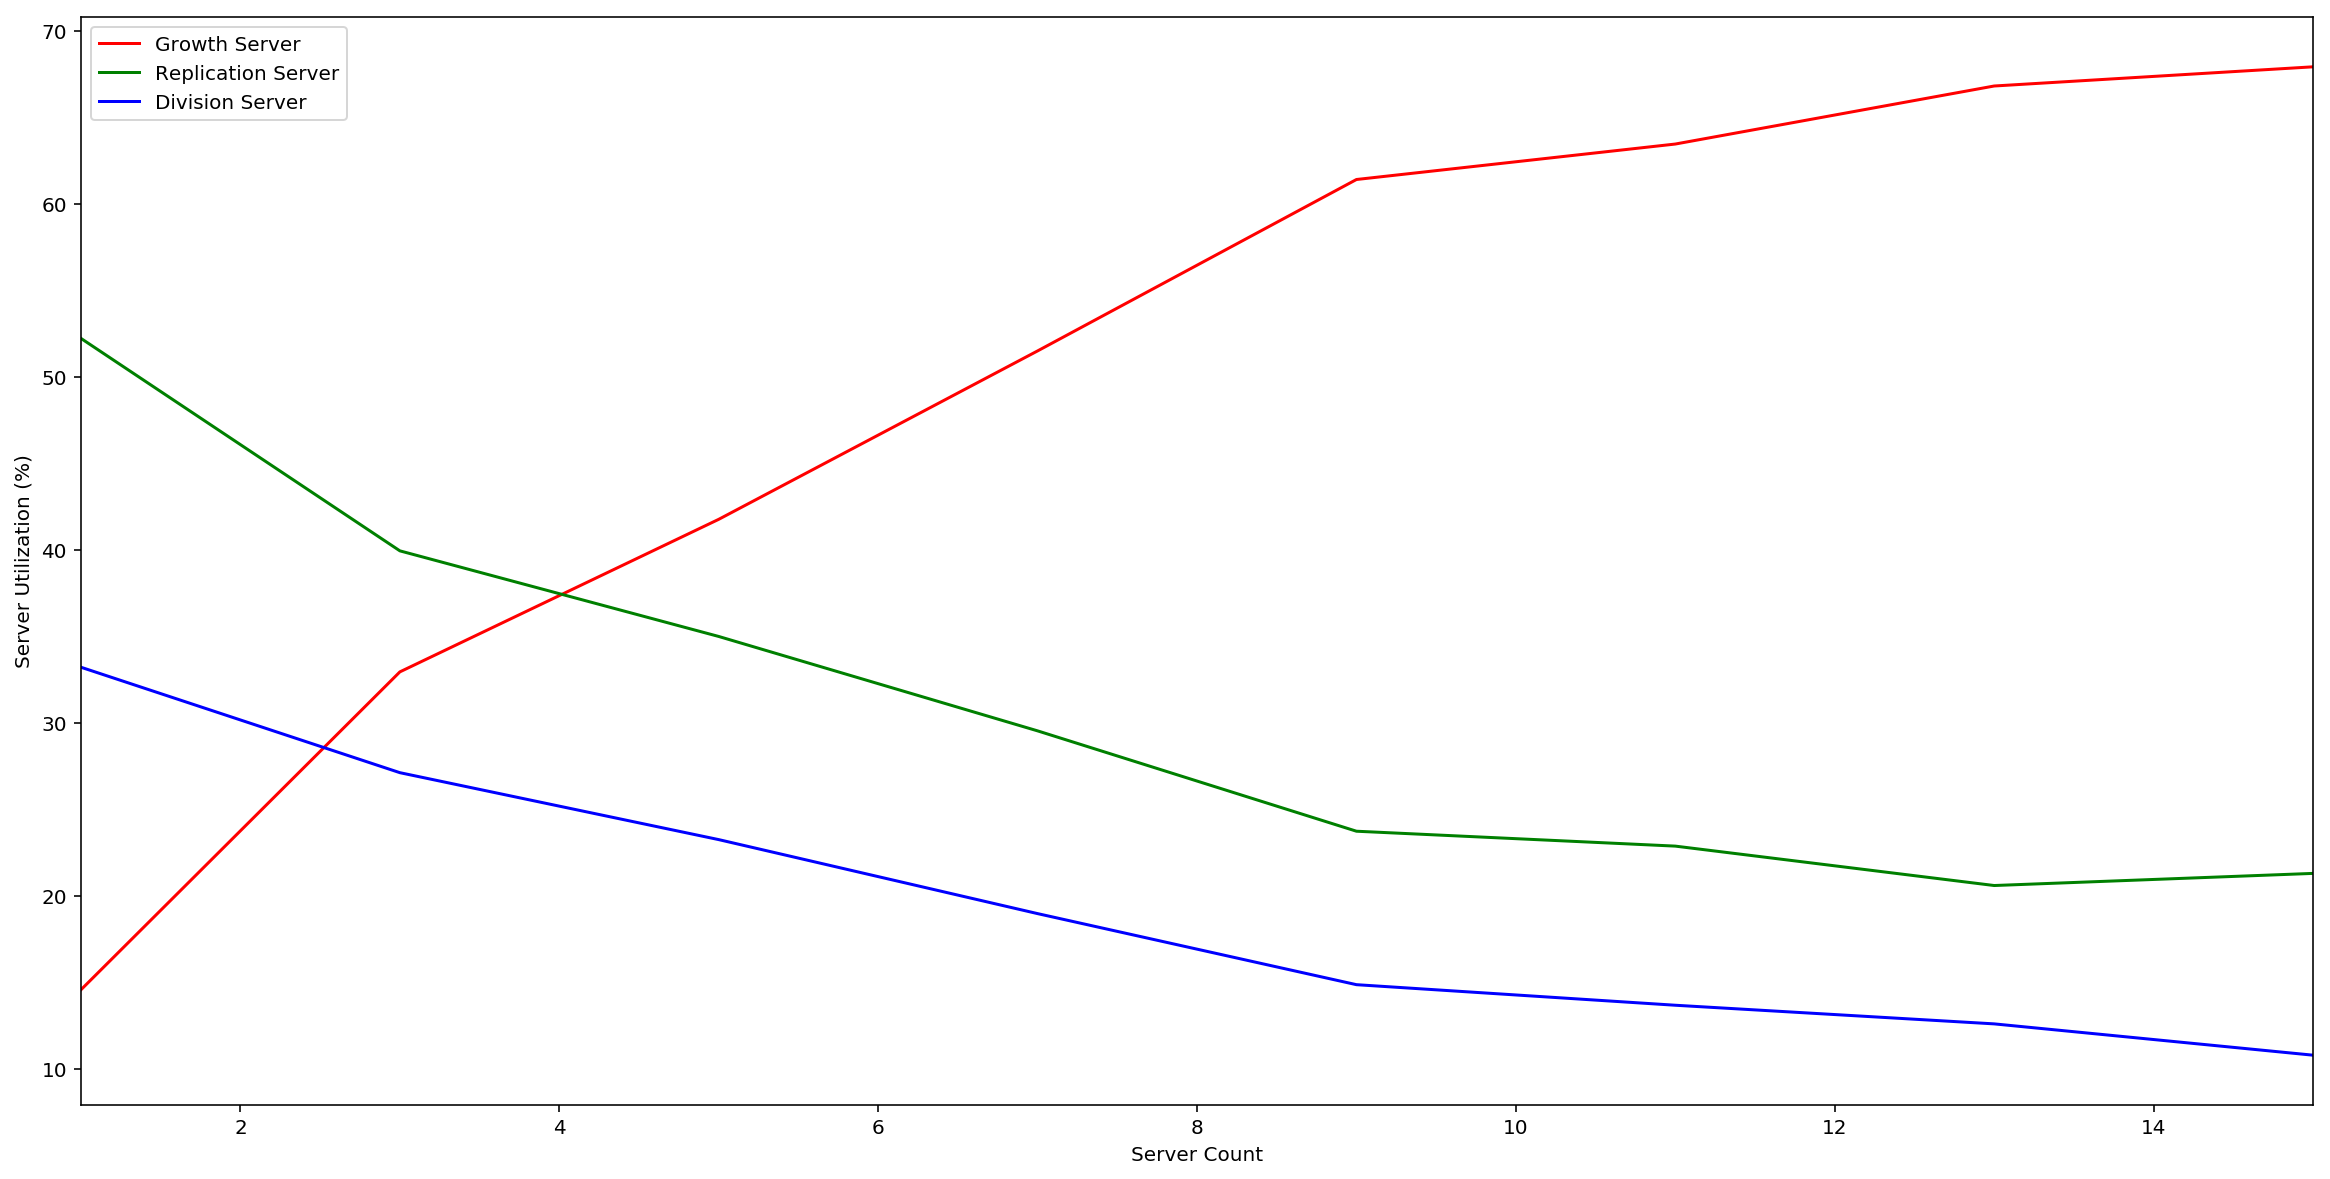

In [13]:
random.seed(100)
X,Y1,Y2,Y3 = [],[],[],[]

for x in range(1, 16, 2):
    totalReplicationServer = x
    totalDivisionServer = x
    run(100,totalReplicationServer,totalDivisionServer)
    gsUtility = (sum(growthServerUse) / float(simClock)) * 100
    dsUtility = (sum(replicationServerUse) / float(simClock)) * 100
    msUtility = (sum(divisionServerUse) / float(simClock)) * 100

    X.append(x)
    Y1.append(gsUtility)
    Y2.append(dsUtility)
    Y3.append(msUtility)

plt.figure(figsize=(20,10))
growth, = plt.plot(X,Y1,'r-',label='GrowthServiceTime')
dna, = plt.plot(X,Y2,'g-',label='msServiceTime')
mitosis, = plt.plot(X,Y3,'b-',label='msServiceTime')
plt.legend([growth, dna, mitosis], ['Growth Server','Replication Server', 'Division Server'])
# plt.suptitle("Server Utilization Vs Server Count", fontsize=16)
plt.xlabel("Server Count")
plt.ylabel("Server Utilization (%)")
plt.xlim([1,15])
plt.show()

# Impact Of Seed (Random Distribution) Changes : Growth Server

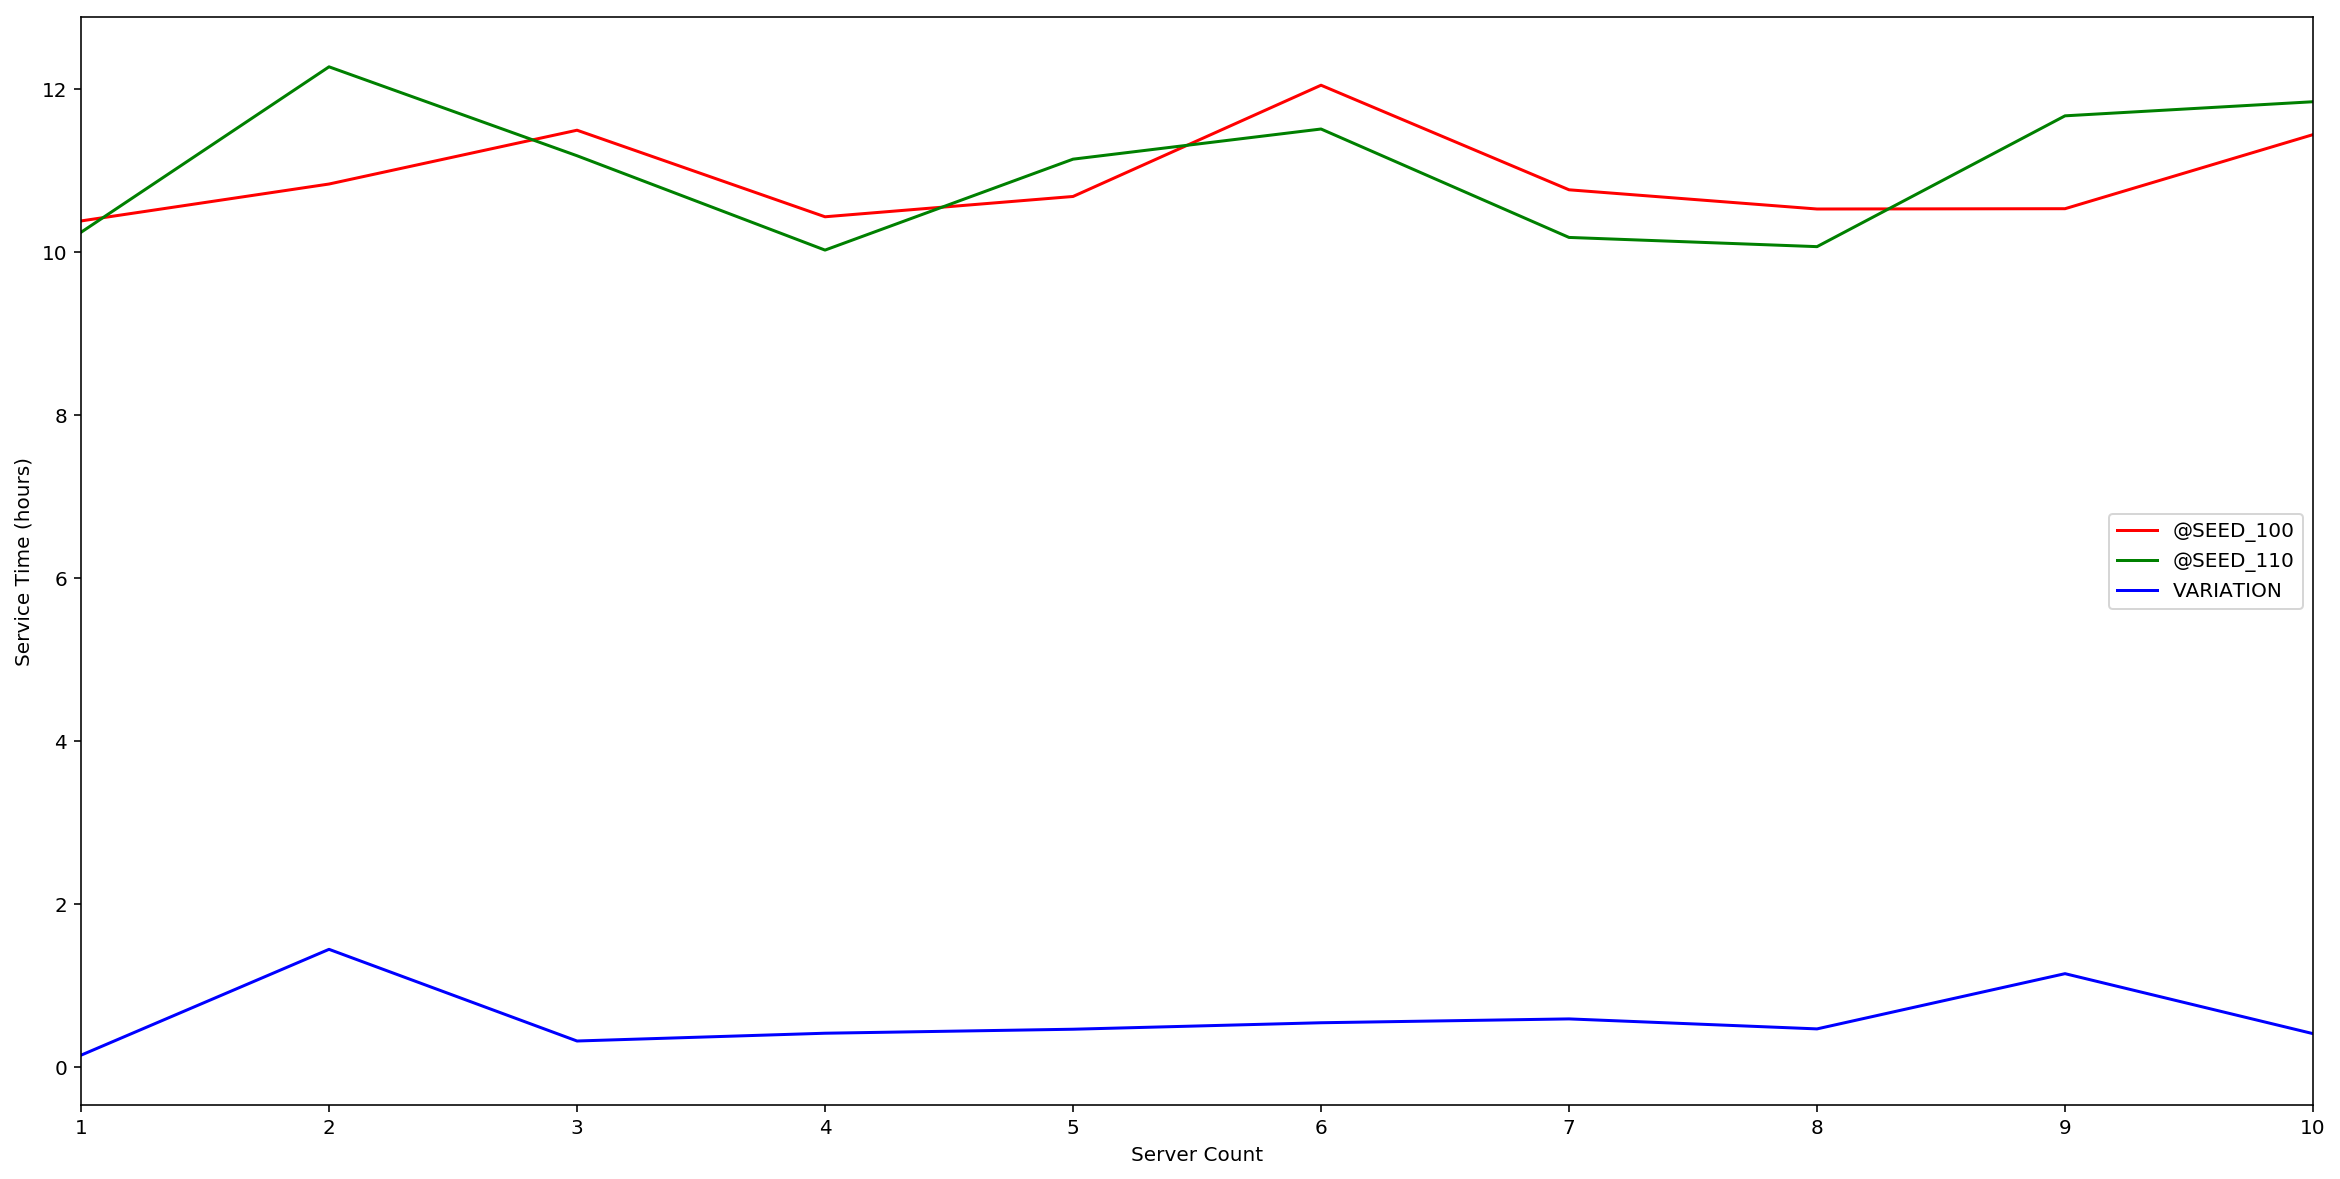

In [14]:
X,Y1,Y2,Y3 = [],[],[],[]

random.seed(100)
for x in range(1,11):
    totalReplicationServer = x
    totalDivisionServer = x
    run(100,totalReplicationServer,totalDivisionServer)
    Avg_gsServiceTime = sum(gsServiceTime) / float(len(gsServiceTime))
    X.append(x)
    Y1.append(Avg_gsServiceTime)

random.seed(110)
for x in range(1,11):
    totalReplicationServer = x
    totalDivisionServer = x
    run(100,totalReplicationServer,totalDivisionServer)
    Avg_gsServiceTime = sum(gsServiceTime) / float(len(gsServiceTime))
    Y2.append(Avg_gsServiceTime)

for x in range(10):
    Y3.append(abs(Y1[x]-Y2[x]))

plt.figure(figsize=(20,10))
seed_100, = plt.plot(X,Y1,'r-',label='SEED_100')
seed_110, = plt.plot(X,Y2,'g-',label='SEED_110')
variation, = plt.plot(X,Y3,'b-',label='VARIATION')
plt.legend([seed_100, seed_110, variation], ['@SEED_100','@SEED_110', 'VARIATION'])
# plt.suptitle("Impact Of Seed Changes : Growth Server", fontsize=16)
plt.xlabel("Server Count")
plt.ylabel("Service Time (hours)")
plt.xlim([1,10])
plt.show()

# Impact Of Seed (Random Distribution) Changes : Replication Server

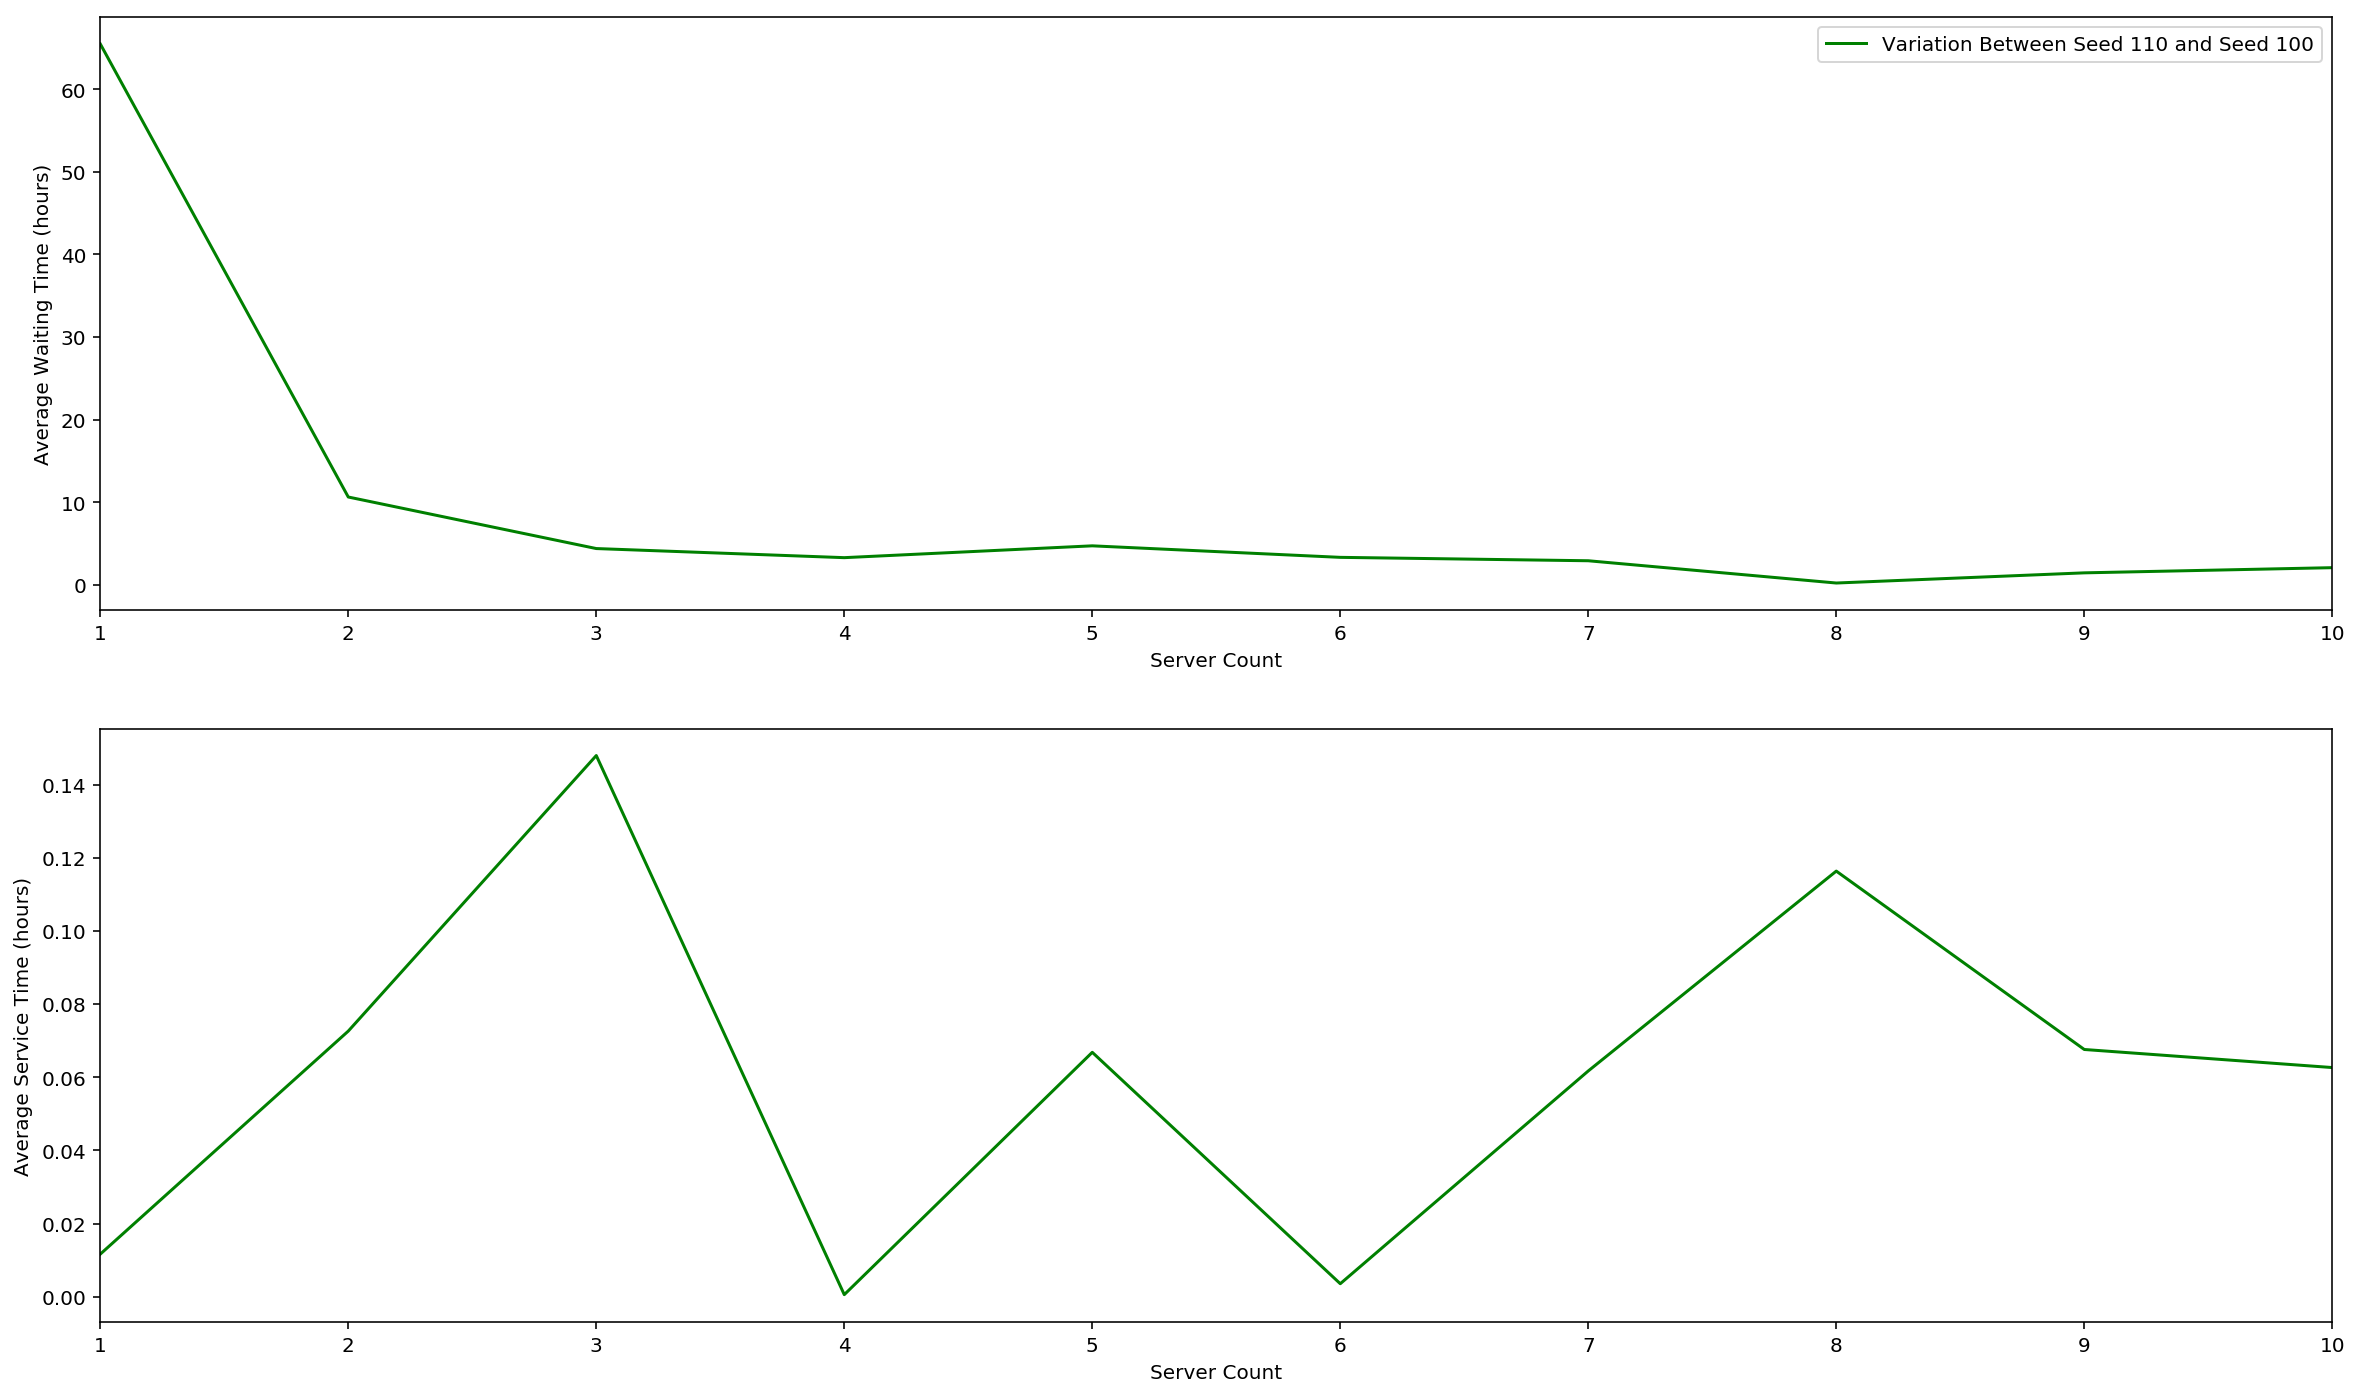

In [15]:
X,Y1,Y2,Y3,Y4,Y5,Y6 = [],[],[],[],[],[],[]

random.seed(100)
for x in range(1,11):
    totalReplicationServer = x
    totalDivisionServer = x
    run(100,totalReplicationServer,totalDivisionServer)
    Avg_rsWaitingTime = sum(rsWaitingTime) / float(len(rsWaitingTime)) / totalReplicationServer
    Avg_rsServiceTime = sum(rsServiceTime) / float(len(rsServiceTime))
    X.append(x)
    Y1.append(Avg_rsWaitingTime)
    Y4.append(Avg_rsServiceTime)

random.seed(110)
for x in range(1,11):
    totalReplicationServer = x
    totalDivisionServer = x
    run(100,totalReplicationServer,totalDivisionServer)
    Avg_rsWaitingTime = sum(rsWaitingTime) / float(len(rsWaitingTime)) / totalReplicationServer
    Avg_rsServiceTime = sum(rsServiceTime) / float(len(rsServiceTime))
    Y2.append(Avg_rsWaitingTime)
    Y5.append(Avg_rsServiceTime)

for x in range(10):
    Y3.append(abs(Y1[x]-Y2[x]))
    Y6.append(abs(Y4[x]-Y5[x]))

plt.figure(figsize=(20,12))
plt.subplot(211)
#seed_100, = plt.plot(X,Y1,'r-',label='SEED_100')
#seed_110, = plt.plot(X,Y2,'b-',label='SEED_110')
variation, = plt.plot(X,Y3,'g-',label='VARIATION')
plt.legend([variation], ['Variation Between Seed 110 and Seed 100'])
# plt.suptitle("Impact Of Seed Changes : Replication Server", fontsize=16)
plt.xlabel("Server Count")
plt.ylabel("Average Waiting Time (hours)")
plt.xlim([1,10])

plt.subplot(212)
#seed_100, = plt.plot(X,Y4,'r-',label='SEED_100')
#seed_110, = plt.plot(X,Y5,'b-',label='SEED_110')
variation, = plt.plot(X,Y6,'g-',label='VARIATION')
plt.xlabel("Server Count")
plt.ylabel("Average Service Time (hours)")
plt.xlim([1,10])
plt.show()

# Impact Of Seed (Random Distribution) Changes : Division Server

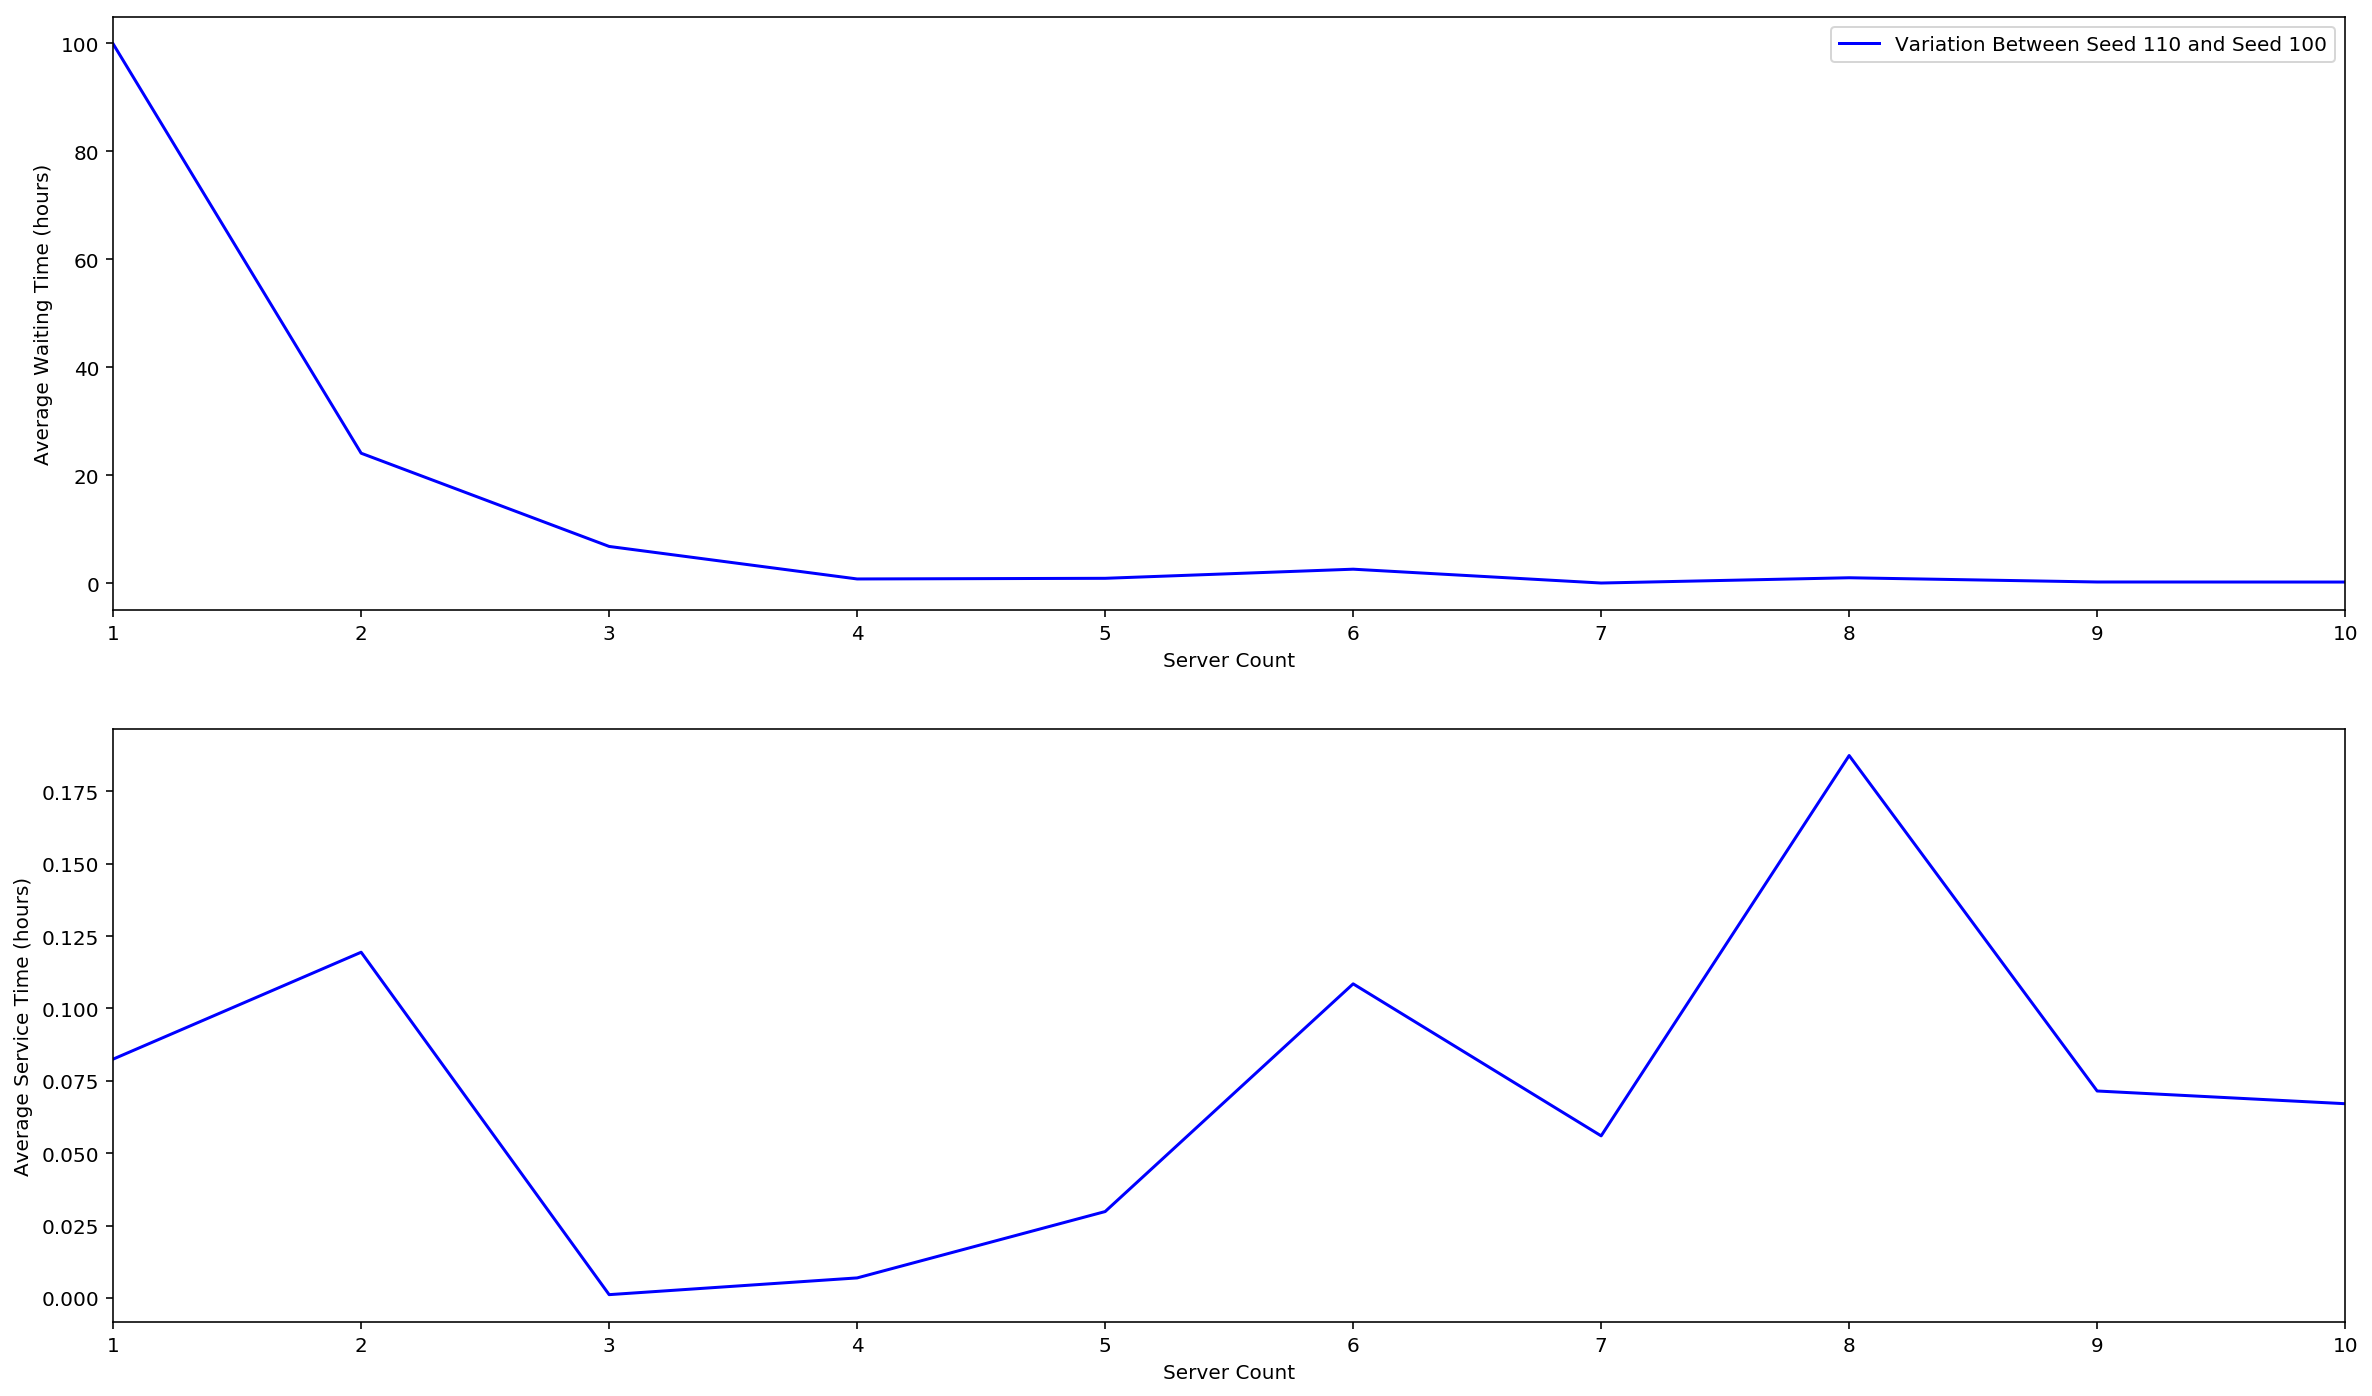

In [16]:
X,Y1,Y2,Y3,Y4,Y5,Y6 = [],[],[],[],[],[],[]

random.seed(100)
for x in range(1,11):
    totalReplicationServer = x
    totalDivisionServer = x
    run(100,totalReplicationServer,totalDivisionServer)
    Avg_dsWaitingTime = sum(dsWaitingTime) / float(len(dsWaitingTime)) / totalDivisionServer
    Avg_dsServiceTime = sum(dsServiceTime) / float(len(dsServiceTime))
    X.append(x)
    Y1.append(Avg_dsWaitingTime)
    Y4.append(Avg_dsServiceTime)

random.seed(110)
for x in range(1,11):
    totalReplicationServer = x
    totalDivisionServer = x
    run(100,totalReplicationServer,totalDivisionServer)
    Avg_dsWaitingTime = sum(dsWaitingTime) / float(len(dsWaitingTime)) / totalDivisionServer
    Avg_dsServiceTime = sum(dsServiceTime) / float(len(dsServiceTime))
    Y2.append(Avg_dsWaitingTime)
    Y5.append(Avg_dsServiceTime)

for x in range(10):
    Y3.append(abs(Y1[x]-Y2[x]))
    Y6.append(abs(Y4[x]-Y5[x]))

plt.figure(figsize=(20,12))
plt.subplot(211)
#seed_100, = plt.plot(X,Y1,'r-',label='SEED_100')
#seed_110, = plt.plot(X,Y2,'g-',label='SEED_110')
variation, = plt.plot(X,Y3,'b-',label='VARIATION')
plt.legend([variation], ['Variation Between Seed 110 and Seed 100'])
# plt.suptitle("Impact Of Seed Changes : Division Server", fontsize=16)
plt.xlabel("Server Count")
plt.ylabel("Average Waiting Time (hours)")
plt.xlim([1,10])

plt.subplot(212)
#seed_100, = plt.plot(X,Y4,'r-',label='SEED_100')
#seed_110, = plt.plot(X,Y5,'g-',label='SEED_110')
variation, = plt.plot(X,Y6,'b-',label='VARIATION')
plt.xlabel("Server Count")
plt.ylabel("Average Service Time (hours)")
plt.xlim([1,10])
plt.show()

# Impact Of Seed (Random Distribution) Changes : Divided and Dead Cell

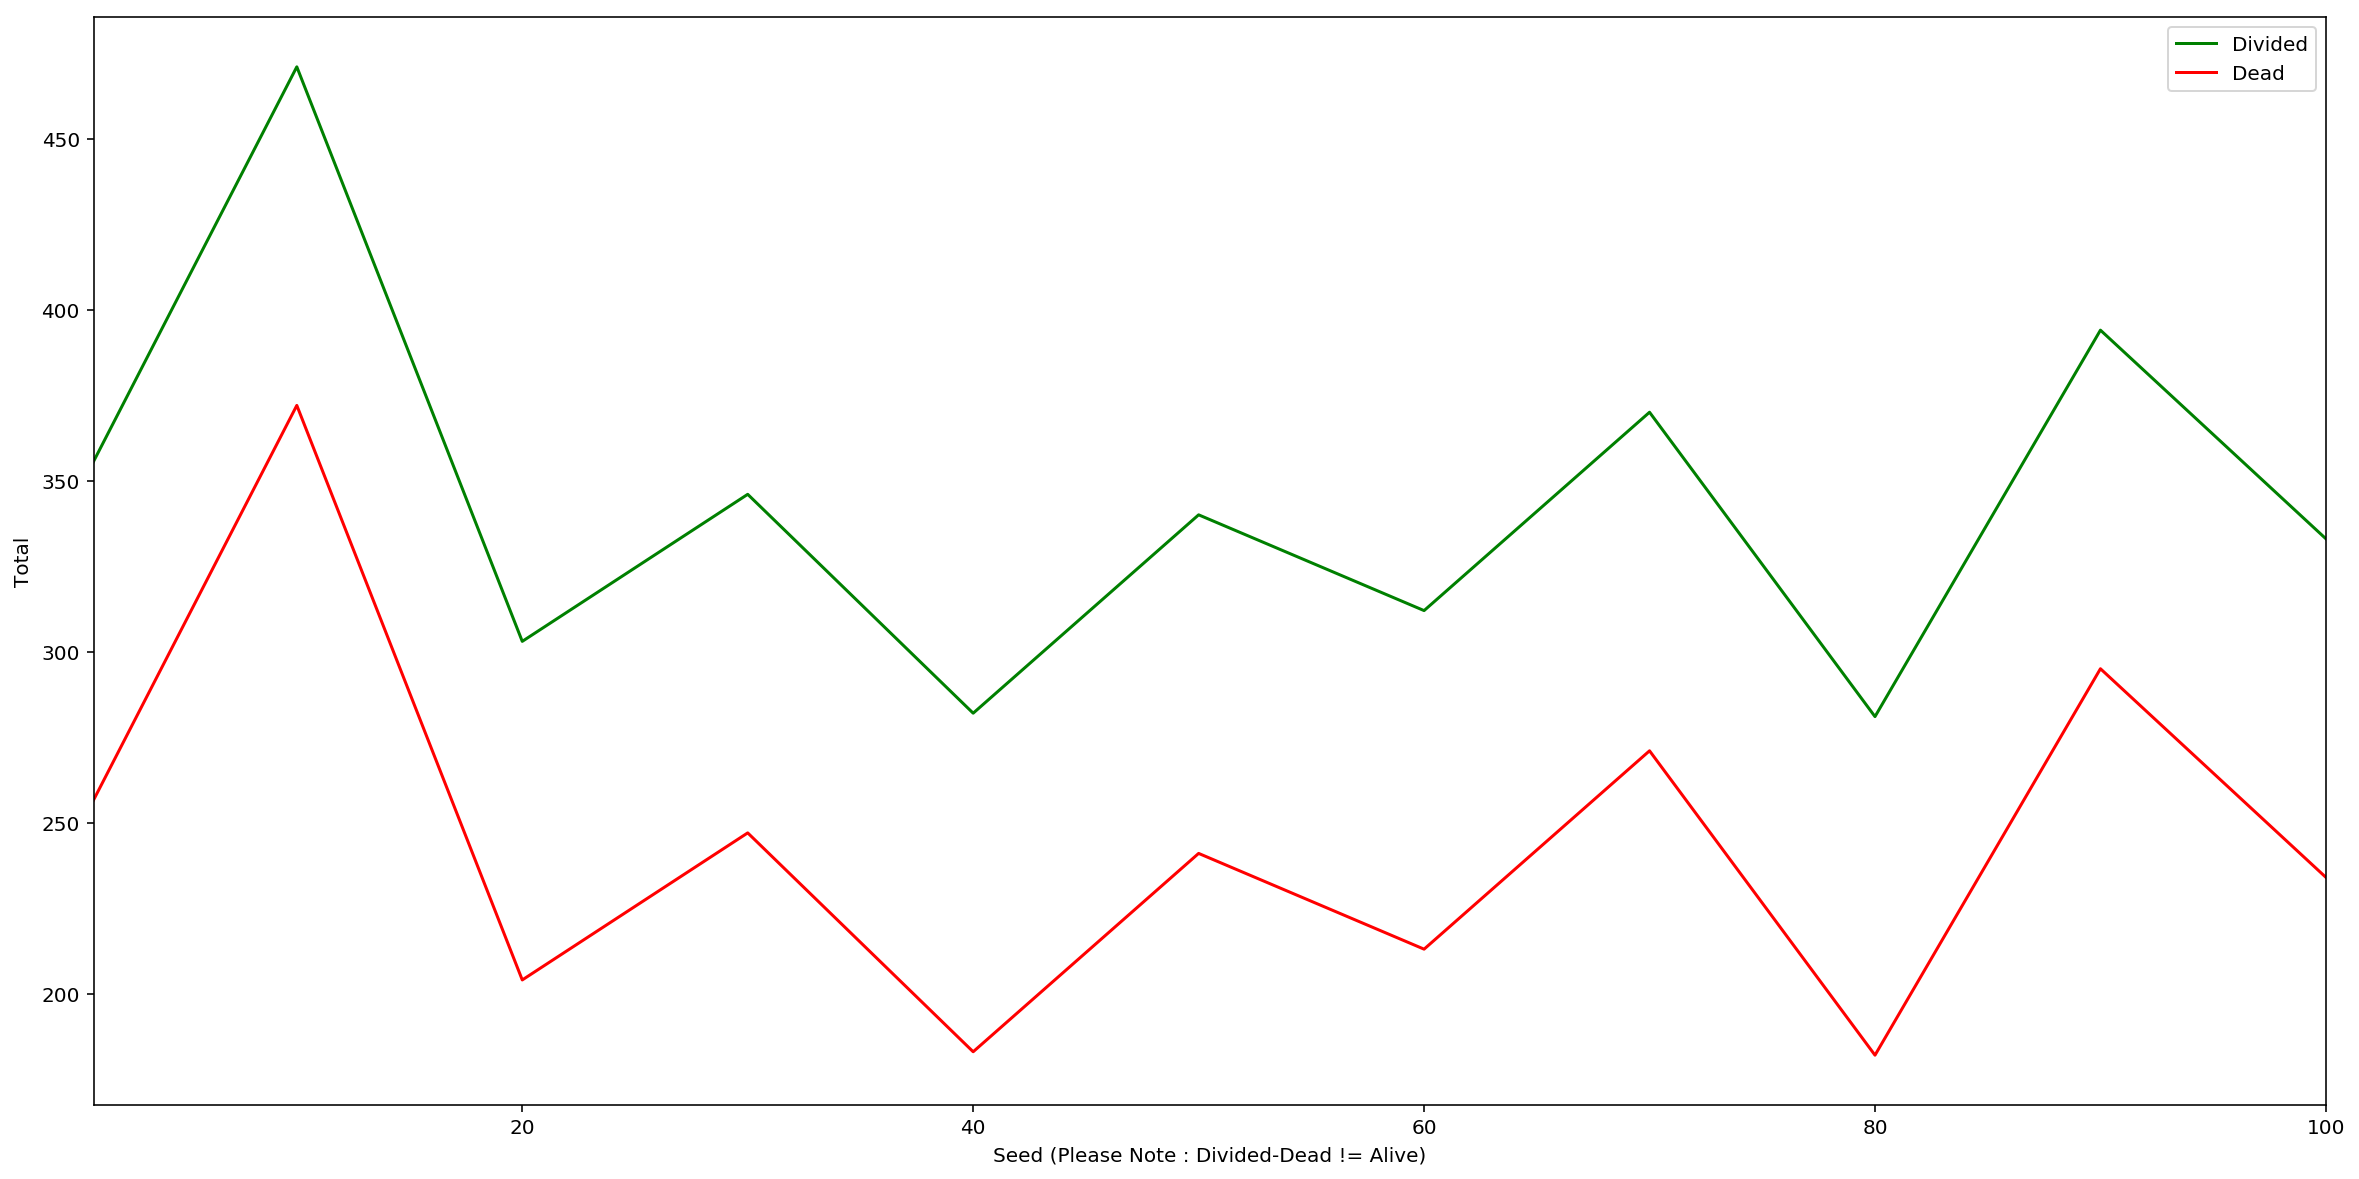

In [17]:
X,Y1,Y2 = [],[],[]

for x in range(11):
    random.seed(x*10)
    run(100,5,5)
    X.append(x*10)
    Y1.append(divided)
    Y2.append(dead)

plt.figure(figsize=(20,10))
divide, = plt.plot(X,Y1,'g-',label='Divided')
dead1, = plt.plot(X,Y2,'r-',label='Dead')
plt.legend([divide, dead1], ['Divided','Dead'])
# plt.suptitle("Impact Of Seed Changes : Divided and Dead Cell", fontsize=16)
plt.xlabel("Seed (Please Note : Divided-Dead != Alive)")
plt.ylabel("Total")
plt.xlim([1,100])
plt.show()

# Helper Function : Get X,Y Axes Values

In [18]:
def getXY(temp):
    temp2,temp3 = [],[]
    minimum = min(temp)
    maximum = max(temp)
#     print(minimum,maximum)
    rangeT = maximum-minimum
    add = rangeT/24.0

    for x in range(25):
        temp2.append(minimum+x*add)

    for x in range(24):
        count = 0
        for y in range(len(temp)):
            if temp[y]>=temp2[x] and temp[y]<temp2[x+1]:
                count = count+1
        temp3.append(count)

    temp3.append(len(temp)-sum(temp3))
    return temp2,temp3

# Growth Server Service Time
    ==> Expected : Exponential Distribution

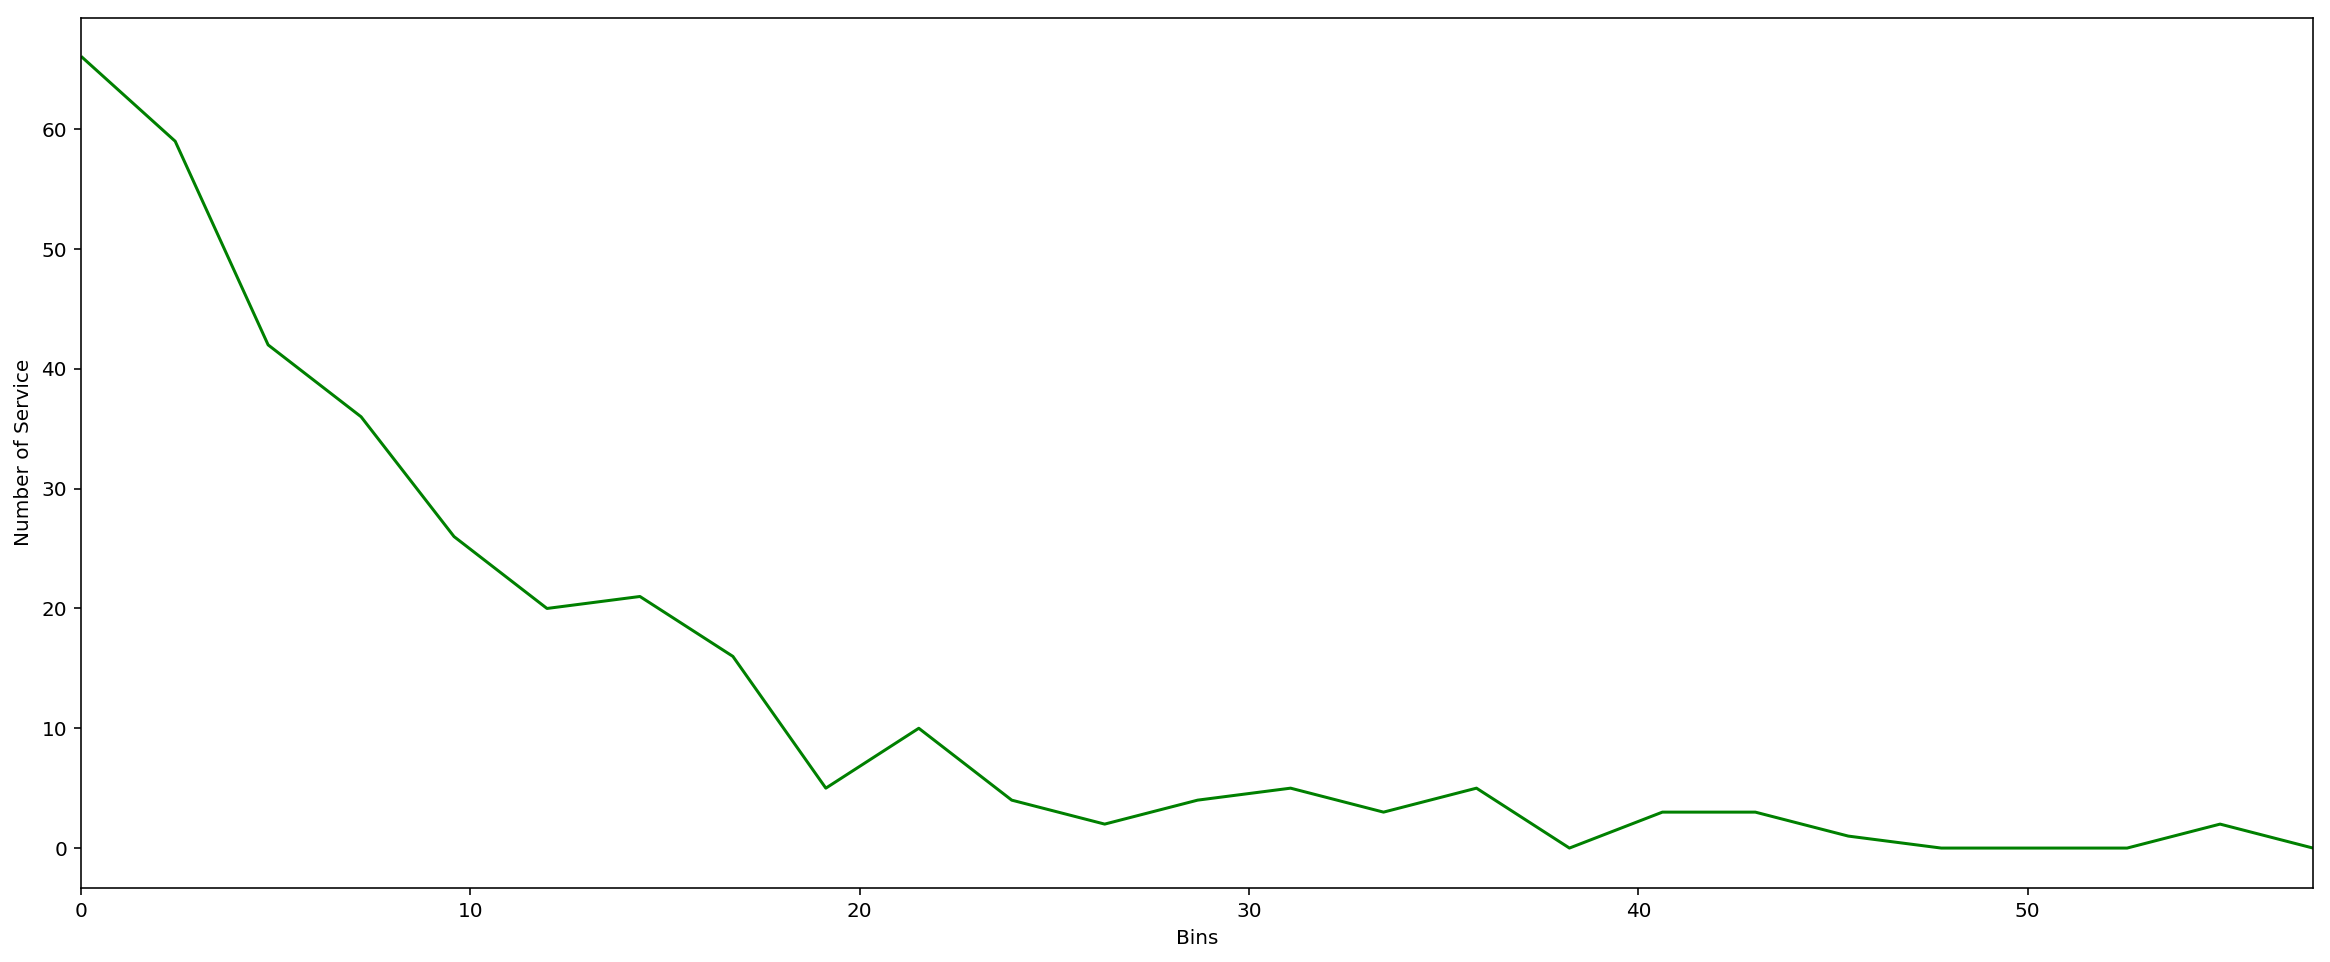

In [19]:
random.seed(100)
X,Y = [],[]

run(100,20,12)
X,Y = getXY(gsServiceTime)

plt.figure(figsize=(20,8))
growth, = plt.plot(X,Y,'g-')
# plt.suptitle("Growth Server Service Time", fontsize=16)
plt.ylabel("Number of Service")
plt.xlabel("Bins")
plt.xlim([0, max(gsServiceTime)])
plt.show()

# Replication Server Service Time
    =>> Expected : Normal Distribution

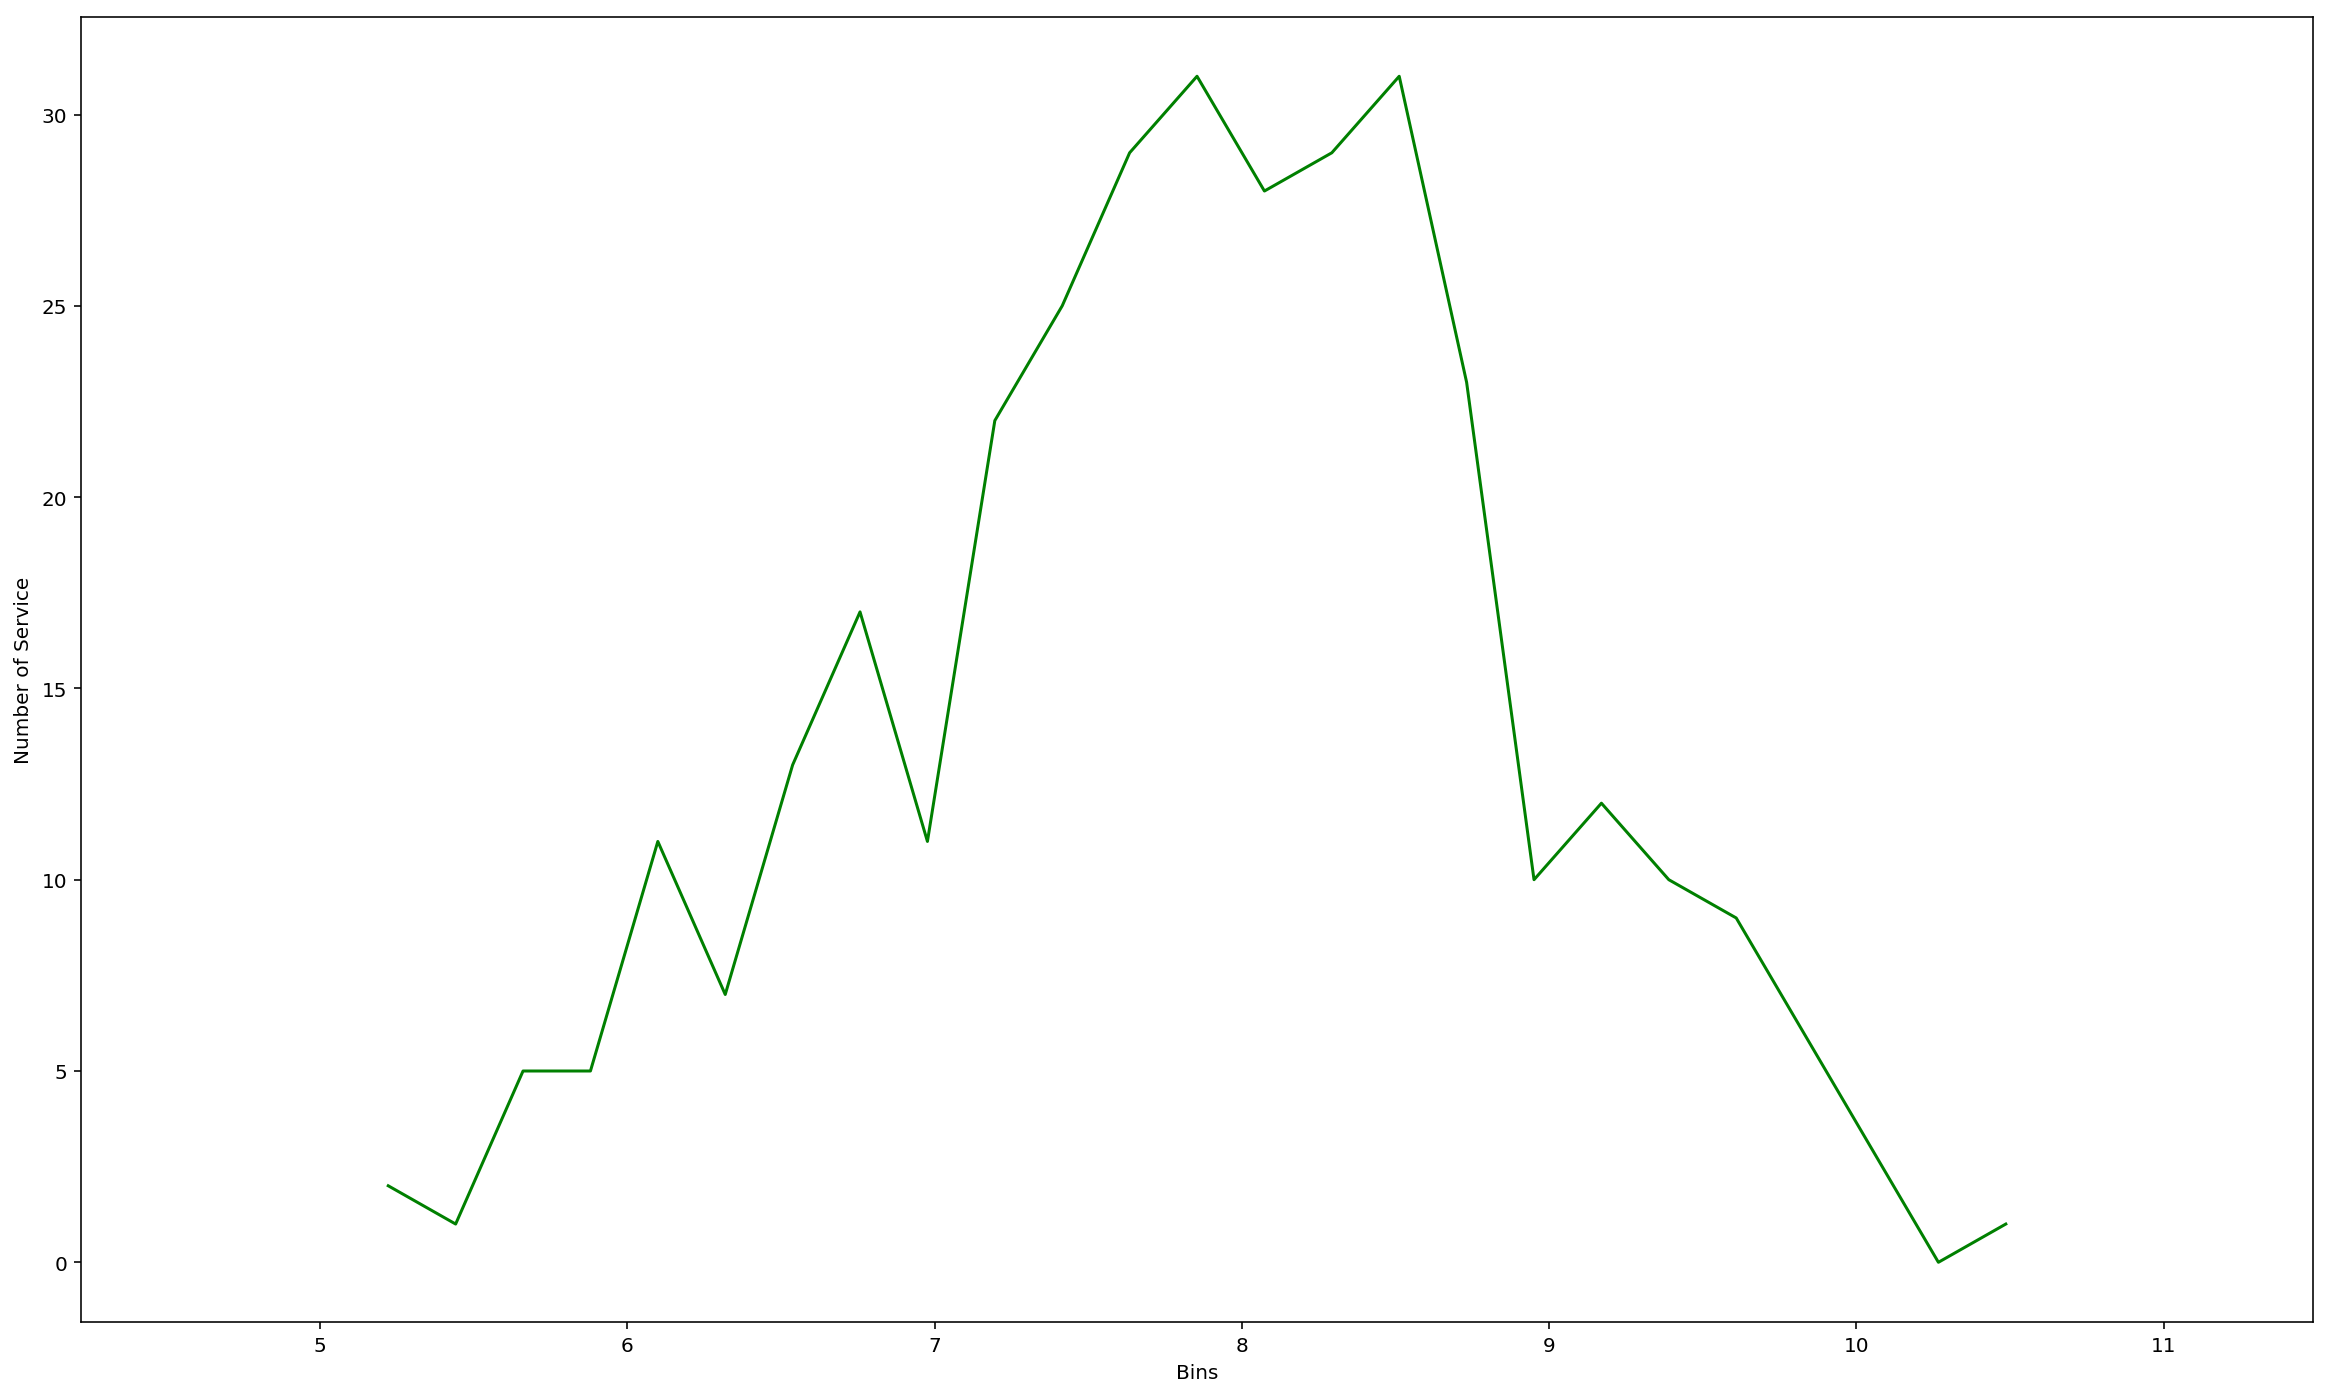

In [20]:
random.seed(5)
X1,Y1 = [],[]

run(100,20,12)
X,Y = getXY(rsServiceTime)

plt.figure(figsize=(20,12))
replicate, = plt.plot(X,Y,'g-')
# plt.suptitle("Replication Server Service Time", fontsize=16)
plt.ylabel("Number of Service")
plt.xlabel("Bins")
plt.xlim([min(rsServiceTime)-1, max(rsServiceTime)+1])
plt.show()

# Division Server Service Time
    ==> Expected : Normal Distribution

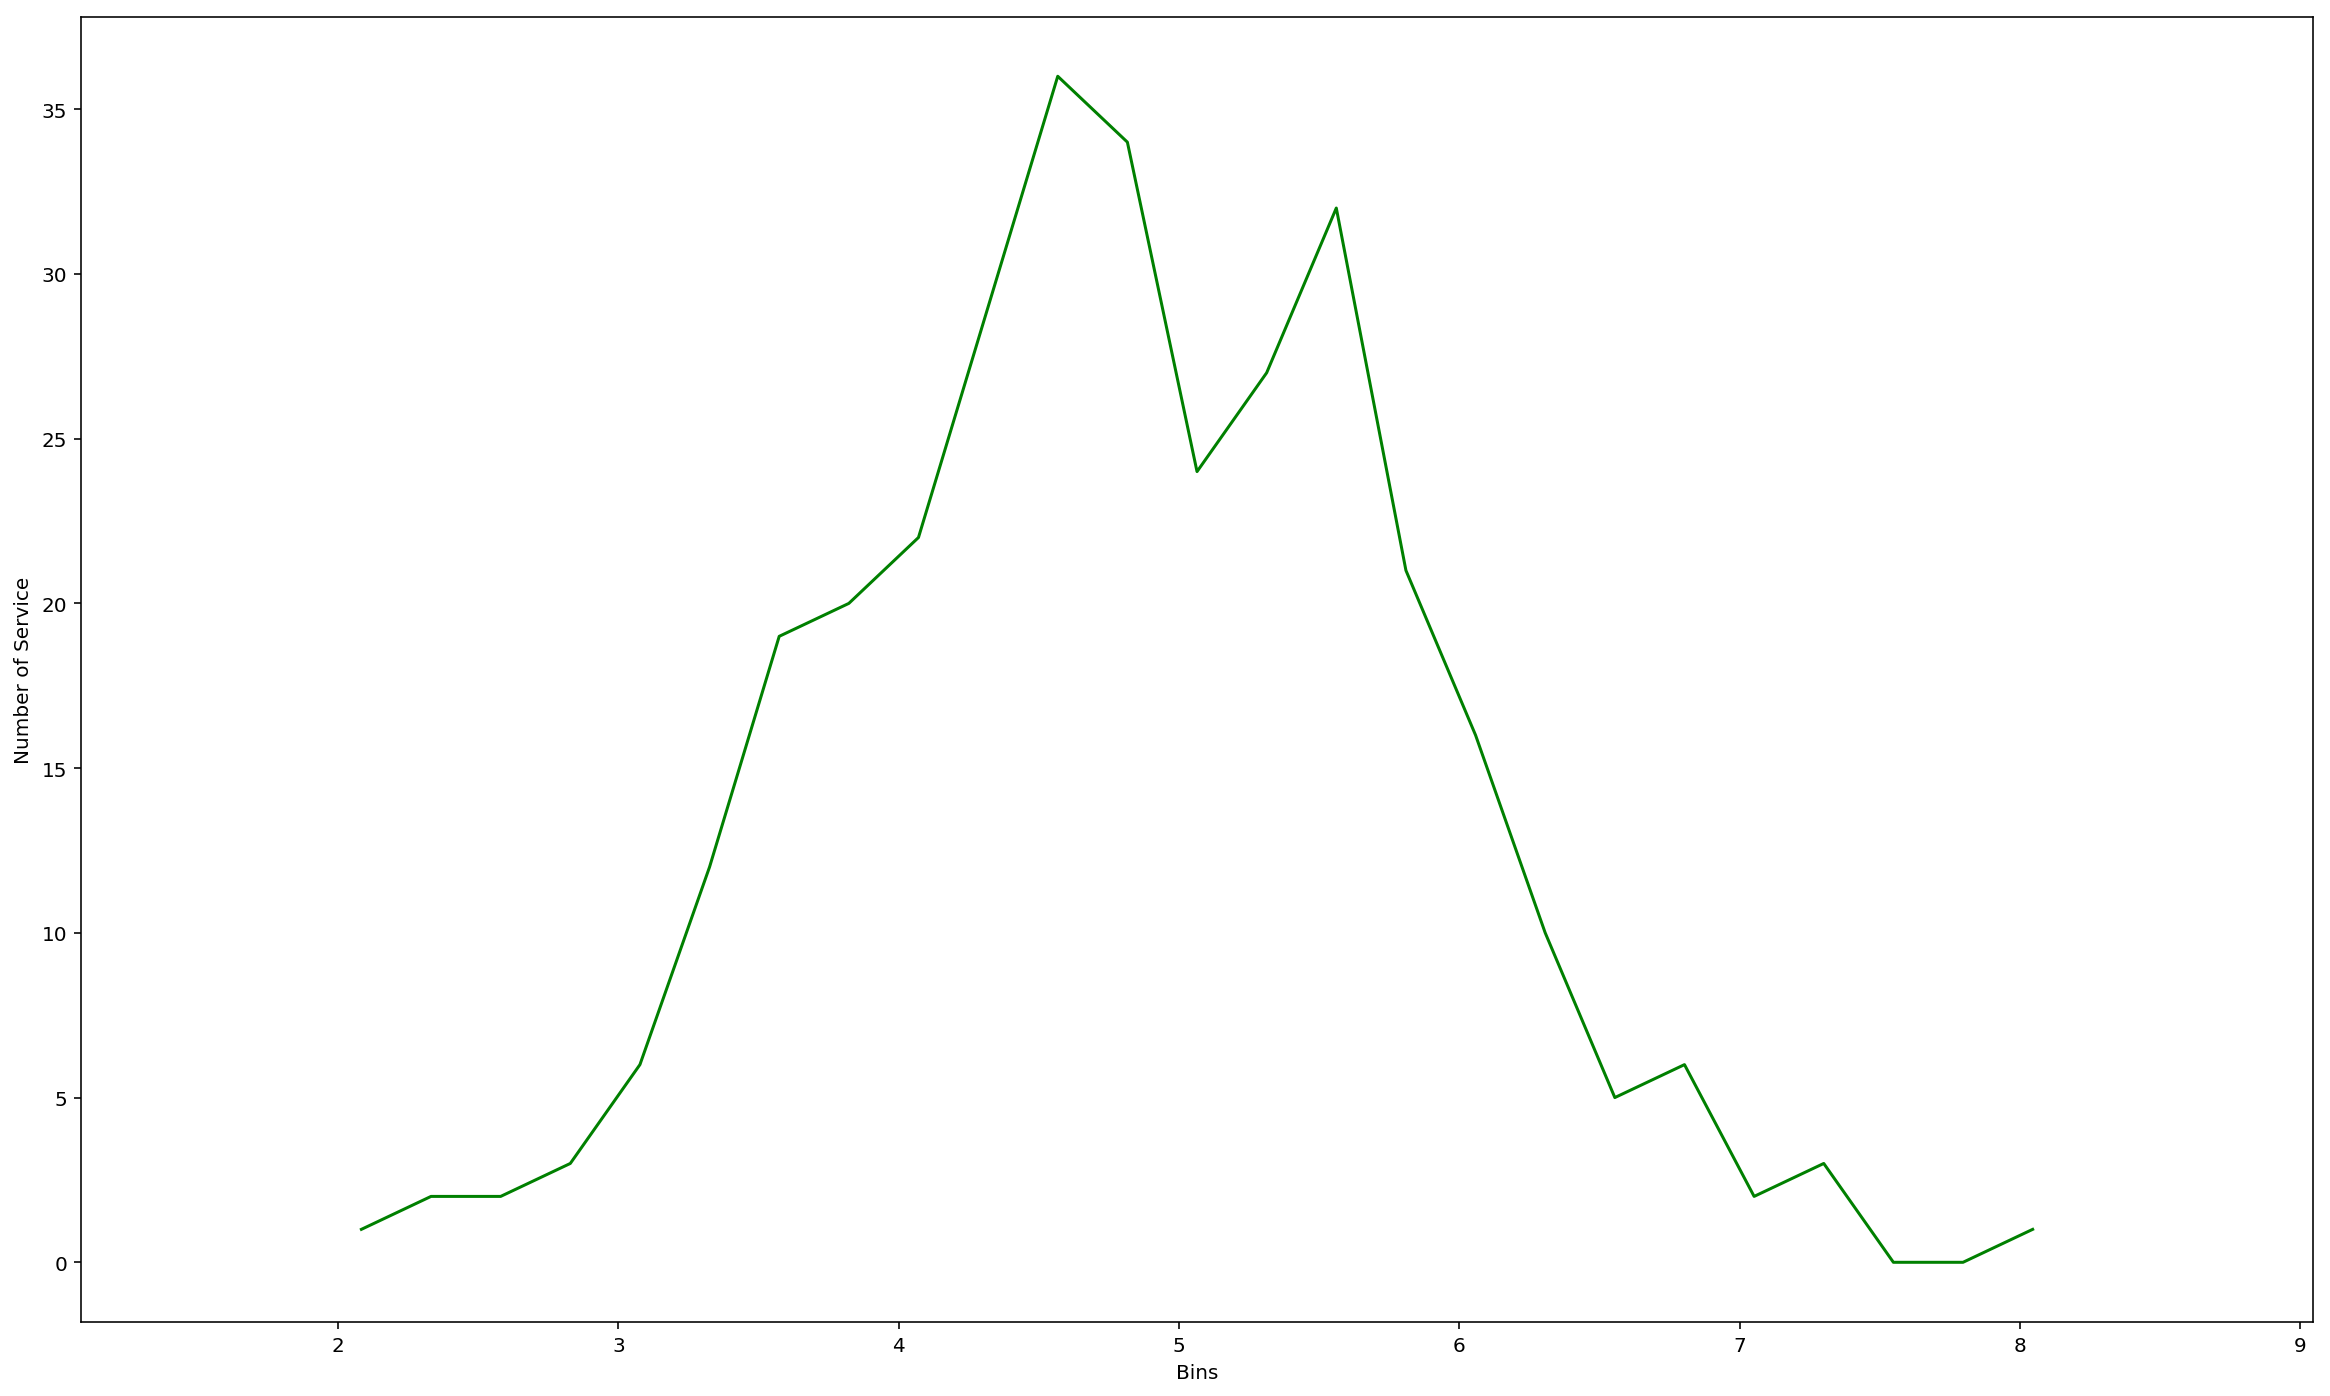

In [21]:
random.seed(100)
X,Y = [],[]

run(100,20,12)
X,Y = getXY(dsServiceTime)

plt.figure(figsize=(20,12))
division, = plt.plot(X,Y,'g-')
# plt.suptitle("Division Server Service Time", fontsize=16)
plt.ylabel("Number of Service")
plt.xlabel("Bins")
plt.xlim([min(dsServiceTime)-1, max(dsServiceTime)+1])
plt.show()

# Sample Simulation Output (Maximum Cell Limit = 10)
    1st Cell is Created!!
    Cell 1 has Started to Grow at 0
    Cell 1 Completes it's Growth at 0
    Cell 1 Joins Replication Server Queue at 0
    A Cell Completes it's Division at 9 and Created Two New Cell 2 and 3
    Yeah!! Cell 2 is Alive and Joined Cell Growth Queue
    Alas!! Cell 3 Has Been Died.
    Total Cell Present : 1
    Cell 2 has Started to Grow at 9
    Cell 2 Completes it's Growth at 9
    Cell 2 Joins Replication Server Queue at 9
    A Cell Completes it's Division at 35 and Created Two New Cell 4 and 5
    Alas!! Cell 4 Has Been Died.
    Yeah!! Cell 5 is Alive and Joined Cell Growth Queue
    Total Cell Present : 1
    Cell 5 has Started to Grow at 35
    Cell 5 Completes it's Growth at 35
    Cell 5 Joins Replication Server Queue at 35
    A Cell Completes it's Division at 59 and Created Two New Cell 6 and 7
    Yeah!! Cell 6 is Alive and Joined Cell Growth Queue
    Yeah!! Cell 7 is Alive and Joined Cell Growth Queue
    Total Cell Present : 2
    Cell 6 has Started to Grow at 59
    Cell 6 Completes it's Growth at 59
    Cell 6 Joins Replication Server Queue at 59
    Cell 7 has Started to Grow at 59
    Cell 7 Completes it's Growth at 59
    Cell 7 Joins Replication Server Queue at 59
    A Cell Completes it's Division at 86 and Created Two New Cell 8 and 9
    Alas!! Cell 8 Has Been Died.
    Alas!! Cell 9 Has Been Died.
    Total Cell Present : 0
    A Cell Completes it's Division at 86 and Created Two New Cell 10 and 11
    Alas!! Cell 10 Has Been Died.
    Yeah!! Cell 11 is Alive and Joined Cell Growth Queue
    Total Cell Present : 1
    Cell 11 has Started to Grow at 96
    Cell 11 Completes it's Growth at 96
    Cell 11 Joins Replication Server Queue at 96
    A Cell Completes it's Division at 120 and Created Two New Cell 12 and 13
    Yeah!! Cell 12 is Alive and Joined Cell Growth Queue
    Alas!! Cell 13 Has Been Died.
    Total Cell Present : 1
    Cell 12 has Started to Grow at 120
    Cell 12 Completes it's Growth at 120
    Cell 12 Joins Replication Server Queue at 120
    A Cell Completes it's Division at 148 and Created Two New Cell 14 and 15
    Alas!! Cell 14 Has Been Died.
    Yeah!! Cell 15 is Alive and Joined Cell Growth Queue
    Total Cell Present : 1
    Cell 15 has Started to Grow at 148
    Cell 15 Completes it's Growth at 148
    Cell 15 Joins Replication Server Queue at 148
    A Cell Completes it's Division at 172 and Created Two New Cell 16 and 17
    Yeah!! Cell 16 is Alive and Joined Cell Growth Queue
    Yeah!! Cell 17 is Alive and Joined Cell Growth Queue
    Total Cell Present : 2
    Cell 16 has Started to Grow at 172
    Cell 16 Completes it's Growth at 172
    Cell 16 Joins Replication Server Queue at 172
    Cell 17 has Started to Grow at 172
    Cell 17 Completes it's Growth at 172
    Cell 17 Joins Replication Server Queue at 172
    A Cell Completes it's Division at 205 and Created Two New Cell 18 and 19
    Yeah!! Cell 18 is Alive and Joined Cell Growth Queue
    Yeah!! Cell 19 is Alive and Joined Cell Growth Queue
    Total Cell Present : 2
    A Cell Completes it's Division at 205 and Created Two New Cell 20 and 21
    Alas!! Cell 20 Has Been Died.
    Yeah!! Cell 21 is Alive and Joined Cell Growth Queue
    Total Cell Present : 3
    Cell 18 has Started to Grow at 212
    Cell 18 Completes it's Growth at 212
    Cell 18 Joins Replication Server Queue at 212
    Cell 19 has Started to Grow at 212
    Cell 19 Completes it's Growth at 212
    Cell 19 Joins Replication Server Queue at 212
    Cell 21 has Started to Grow at 212
    Cell 21 Completes it's Growth at 212
    Cell 21 Joins Replication Server Queue at 212
    A Cell Completes it's Division at 245 and Created Two New Cell 22 and 23
    Yeah!! Cell 22 is Alive and Joined Cell Growth Queue
    Yeah!! Cell 23 is Alive and Joined Cell Growth Queue
    Total Cell Present : 2
    A Cell Completes it's Division at 245 and Created Two New Cell 24 and 25
    Alas!! Cell 24 Has Been Died.
    Yeah!! Cell 25 is Alive and Joined Cell Growth Queue
    Total Cell Present : 3
    A Cell Completes it's Division at 245 and Created Two New Cell 26 and 27
    Yeah!! Cell 26 is Alive and Joined Cell Growth Queue
    Alas!! Cell 27 Has Been Died.
    Total Cell Present : 4
    Cell 22 has Started to Grow at 258
    Cell 22 Completes it's Growth at 258
    Cell 22 Joins Replication Server Queue at 258
    Cell 23 has Started to Grow at 258
    Cell 23 Completes it's Growth at 258
    Cell 23 Joins Replication Server Queue at 258
    Cell 25 has Started to Grow at 258
    Cell 25 Completes it's Growth at 258
    Cell 25 Joins Replication Server Queue at 258
    Cell 26 has Started to Grow at 258
    Cell 26 Completes it's Growth at 258
    Cell 26 Joins Replication Server Queue at 258
    A Cell Completes it's Division at 310 and Created Two New Cell 28 and 29
    Alas!! Cell 28 Has Been Died.
    Yeah!! Cell 29 is Alive and Joined Cell Growth Queue
    Total Cell Present : 1
    A Cell Completes it's Division at 310 and Created Two New Cell 30 and 31
    Yeah!! Cell 30 is Alive and Joined Cell Growth Queue
    Yeah!! Cell 31 is Alive and Joined Cell Growth Queue
    Total Cell Present : 3
    A Cell Completes it's Division at 310 and Created Two New Cell 32 and 33
    Yeah!! Cell 32 is Alive and Joined Cell Growth Queue
    Yeah!! Cell 33 is Alive and Joined Cell Growth Queue
    Total Cell Present : 5
    A Cell Completes it's Division at 310 and Created Two New Cell 34 and 35
    Yeah!! Cell 34 is Alive and Joined Cell Growth Queue
    Yeah!! Cell 35 is Alive and Joined Cell Growth Queue
    Total Cell Present : 7
    Cell 29 has Started to Grow at 331
    Cell 29 Completes it's Growth at 331
    Cell 29 Joins Replication Server Queue at 331
    Cell 30 has Started to Grow at 331
    Cell 30 Completes it's Growth at 331
    Cell 30 Joins Replication Server Queue at 331
    Cell 31 has Started to Grow at 331
    Cell 31 Completes it's Growth at 331
    Cell 31 Joins Replication Server Queue at 331
    Cell 32 has Started to Grow at 331
    Cell 32 Completes it's Growth at 331
    Cell 32 Joins Replication Server Queue at 331
    Cell 33 has Started to Grow at 331
    Cell 33 Completes it's Growth at 331
    Cell 33 Joins Replication Server Queue at 331
    Cell 34 has Started to Grow at 331
    Cell 34 Completes it's Growth at 331
    Cell 34 Joins Replication Server Queue at 331
    Cell 35 has Started to Grow at 331
    Cell 35 Completes it's Growth at 331
    Cell 35 Joins Replication Server Queue at 331
    A Cell Completes it's Division at 395 and Created Two New Cell 36 and 37
    Alas!! Cell 36 Has Been Died.
    Alas!! Cell 37 Has Been Died.
    Total Cell Present : 0
    A Cell Completes it's Division at 395 and Created Two New Cell 38 and 39
    Yeah!! Cell 38 is Alive and Joined Cell Growth Queue
    Yeah!! Cell 39 is Alive and Joined Cell Growth Queue
    Total Cell Present : 2
    A Cell Completes it's Division at 395 and Created Two New Cell 40 and 41
    Yeah!! Cell 40 is Alive and Joined Cell Growth Queue
    Yeah!! Cell 41 is Alive and Joined Cell Growth Queue
    Total Cell Present : 4
    A Cell Completes it's Division at 395 and Created Two New Cell 42 and 43
    Alas!! Cell 42 Has Been Died.
    Alas!! Cell 43 Has Been Died.
    Total Cell Present : 4
    A Cell Completes it's Division at 395 and Created Two New Cell 44 and 45
    Yeah!! Cell 44 is Alive and Joined Cell Growth Queue
    Alas!! Cell 45 Has Been Died.
    Total Cell Present : 5
    A Cell Completes it's Division at 395 and Created Two New Cell 46 and 47
    Alas!! Cell 46 Has Been Died.
    Yeah!! Cell 47 is Alive and Joined Cell Growth Queue
    Total Cell Present : 6
    A Cell Completes it's Division at 395 and Created Two New Cell 48 and 49
    Yeah!! Cell 48 is Alive and Joined Cell Growth Queue
    Yeah!! Cell 49 is Alive and Joined Cell Growth Queue
    Total Cell Present : 8
    Cell 38 has Started to Grow at 429
    Cell 38 Completes it's Growth at 429
    Cell 38 Joins Replication Server Queue at 429
    Cell 39 has Started to Grow at 429
    Cell 39 Completes it's Growth at 429
    Cell 39 Joins Replication Server Queue at 429
    Cell 40 has Started to Grow at 429
    Cell 40 Completes it's Growth at 429
    Cell 40 Joins Replication Server Queue at 429
    Cell 41 has Started to Grow at 429
    Cell 41 Completes it's Growth at 429
    Cell 41 Joins Replication Server Queue at 429
    Cell 44 has Started to Grow at 429
    Cell 44 Completes it's Growth at 429
    Cell 44 Joins Replication Server Queue at 429
    Cell 47 has Started to Grow at 429
    Cell 47 Completes it's Growth at 429
    Cell 47 Joins Replication Server Queue at 429
    Cell 48 has Started to Grow at 429
    Cell 48 Completes it's Growth at 429
    Cell 48 Joins Replication Server Queue at 429
    Cell 49 has Started to Grow at 429
    Cell 49 Completes it's Growth at 429
    Cell 49 Joins Replication Server Queue at 429
    A Cell Completes it's Division at 497 and Created Two New Cell 50 and 51
    Alas!! Cell 50 Has Been Died.
    Yeah!! Cell 51 is Alive and Joined Cell Growth Queue
    Total Cell Present : 1
    A Cell Completes it's Division at 497 and Created Two New Cell 52 and 53
    Alas!! Cell 52 Has Been Died.
    Alas!! Cell 53 Has Been Died.
    Total Cell Present : 1
    A Cell Completes it's Division at 497 and Created Two New Cell 54 and 55
    Alas!! Cell 54 Has Been Died.
    Alas!! Cell 55 Has Been Died.
    Total Cell Present : 1
    A Cell Completes it's Division at 497 and Created Two New Cell 56 and 57
    Alas!! Cell 56 Has Been Died.
    Yeah!! Cell 57 is Alive and Joined Cell Growth Queue
    Total Cell Present : 2
    A Cell Completes it's Division at 497 and Created Two New Cell 58 and 59
    Yeah!! Cell 58 is Alive and Joined Cell Growth Queue
    Yeah!! Cell 59 is Alive and Joined Cell Growth Queue
    Total Cell Present : 4
    A Cell Completes it's Division at 497 and Created Two New Cell 60 and 61
    Alas!! Cell 60 Has Been Died.
    Yeah!! Cell 61 is Alive and Joined Cell Growth Queue
    Total Cell Present : 5
    A Cell Completes it's Division at 497 and Created Two New Cell 62 and 63
    Yeah!! Cell 62 is Alive and Joined Cell Growth Queue
    Yeah!! Cell 63 is Alive and Joined Cell Growth Queue
    Total Cell Present : 7
    A Cell Completes it's Division at 497 and Created Two New Cell 64 and 65
    Yeah!! Cell 64 is Alive and Joined Cell Growth Queue
    Yeah!! Cell 65 is Alive and Joined Cell Growth Queue
    Total Cell Present : 9
    Cell 51 has Started to Grow at 533
    Cell 51 Completes it's Growth at 533
    Cell 51 Joins Replication Server Queue at 533
    Cell 57 has Started to Grow at 533
    Cell 57 Completes it's Growth at 533
    Cell 57 Joins Replication Server Queue at 533
    Cell 58 has Started to Grow at 533
    Cell 58 Completes it's Growth at 533
    Cell 58 Joins Replication Server Queue at 533
    Cell 59 has Started to Grow at 533
    Cell 59 Completes it's Growth at 533
    Cell 59 Joins Replication Server Queue at 533
    Cell 61 has Started to Grow at 533
    Cell 61 Completes it's Growth at 533
    Cell 61 Joins Replication Server Queue at 533
    Cell 62 has Started to Grow at 533
    Cell 62 Completes it's Growth at 533
    Cell 62 Joins Replication Server Queue at 533
    Cell 63 has Started to Grow at 533
    Cell 63 Completes it's Growth at 533
    Cell 63 Joins Replication Server Queue at 533
    Cell 64 has Started to Grow at 533
    Cell 64 Completes it's Growth at 533
    Cell 64 Joins Replication Server Queue at 533
    Cell 65 has Started to Grow at 533
    Cell 65 Completes it's Growth at 533
    Cell 65 Joins Replication Server Queue at 533
    A Cell Completes it's Division at 609 and Created Two New Cell 66 and 67
    Yeah!! Cell 66 is Alive and Joined Cell Growth Queue
    Yeah!! Cell 67 is Alive and Joined Cell Growth Queue
    Total Cell Present : 2
    A Cell Completes it's Division at 609 and Created Two New Cell 68 and 69
    Yeah!! Cell 68 is Alive and Joined Cell Growth Queue
    Yeah!! Cell 69 is Alive and Joined Cell Growth Queue
    Total Cell Present : 4
    A Cell Completes it's Division at 609 and Created Two New Cell 70 and 71
    Yeah!! Cell 70 is Alive and Joined Cell Growth Queue
    Yeah!! Cell 71 is Alive and Joined Cell Growth Queue
    Total Cell Present : 6
    A Cell Completes it's Division at 609 and Created Two New Cell 72 and 73
    Alas!! Cell 72 Has Been Died.
    Alas!! Cell 73 Has Been Died.
    Total Cell Present : 6
    A Cell Completes it's Division at 609 and Created Two New Cell 74 and 75
    Yeah!! Cell 74 is Alive and Joined Cell Growth Queue
    Yeah!! Cell 75 is Alive and Joined Cell Growth Queue
    Total Cell Present : 8
    A Cell Completes it's Division at 609 and Created Two New Cell 76 and 77
    Yeah!! Cell 76 is Alive and Joined Cell Growth Queue
    Alas!! Cell 77 Has Been Died.
    Total Cell Present : 9
    A Cell Completes it's Division at 609 and Created Two New Cell 78 and 79
    Alas!! Cell 78 Has Been Died.
    Yeah!! Cell 79 is Alive and Joined Cell Growth Queue
    Total Cell Present : 10
    A Cell Completes it's Division at 609 and Created Two New Cell 80 and 81
    Total Cell Present : 10
    A Cell Completes it's Division at 609 and Created Two New Cell 82 and 83
    Total Cell Present : 10